## 1. IMPORT ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## 2. LOAD THE DATASET

In [2]:
data = pd.read_excel('./Surface Water Data Bulbul  Guaging Station 1995-2021 Final.xlsx')
data.head()

,Year,Station,Day,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1995,Bulbul,1.0,0.593,0.47,0.470,0.393,4.741,4.37,3.174,3.445,2.965,4.007,4.443,3.377
1,1995,Bulbul,2.0,0.593,0.47,0.470,0.356,5.120,4.151,3.723,4.443,3.25,4.007,4.296,3.309
2,1995,Bulbul,3.0,0.593,0.47,0.593,0.356,5.197,3.794,4.151,4.443,3.552,3.723,4.37,3.309
3,1995,Bulbul,4.0,0.593,0.47,0.678,0.51,5.044,2.778,3.794,4.223,4.113,3.671,4.591,3.241
4,1995,Bulbul,5.0,0.593,0.47,0.767,0.51,6.306,2.523,3.309,4.007,4.22,3.589,4.517,3.174


In [3]:
# List of stations to keep
stations_to_keep = ["Mean", "Flow (MCM)", "Maximum", "Minimum", "Runoff (mm)"]

# Filter the dataframe
filtered_df = data[data["Station "].isin(stations_to_keep)]
filtered_df.tail()

,Year,Station,Day,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
966,2021,Mean,NaN,0.713,0.316,0.243,0.244,1.091,3.972,17.180,25.200,21.008,8.25,3.015,0.534
967,2021,Flow (MCM),NaN,1.909,0.765,0.650,0.634,2.921,10.297,15.332,10.440,16.683,22.096,7.814,1.431
968,2021,Maximum,NaN,0.994,0.418,0.341,0.356,2.744,5.738,2.866,2.672,2.785,11.999,4.806,1.172
969,2021,Minimum,NaN,0.434,0.233,0.160,0.144,0.231,2.93,2.590,2.530,2.611,4.961,1.366,0.248
970,2021,Runoff (mm),NaN,3.629,1.454,1.236,1.205,5.553,19.575,20.257,21.122,22.661,42.008,14.855,2.721


In [4]:
filtered_df.rename(columns={'Station ':'Parameter'}, inplace=True)
filtered_df.drop(columns={'Day '}, inplace=True)
filtered_df.head()

,Year,Parameter,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
31,1995,Mean,0.460,0.555,0.511,2.048,3.435,2.117,3.487,3.637,3.489,3.671,3.808,3.597
32,1995,Flow (MCM),1.231,1.343,1.370,5.309,9.200,5.486,9.341,9.623,9.578,9.672,9.871,9.633
33,1995,Maximum,0.593,0.722,1.002,6.966,6.306,4.37,4.151,4.593,4.452,4.471,4.591,5.044
34,1995,Minimum,0.356,0.47,0.286,0.286,1.202,0.954,2.398,2.965,2.965,1.151,1.151,3.174
35,1995,Runoff (mm),2.340,2.553,2.604,10.093,17.491,10.43,17.758,17.549,17.2,17.034,18.766,18.314


## 3. TRANSFORM THE DATASET

In [5]:
# Remove extra spaces
filtered_df.columns = filtered_df.columns.str.strip()
filtered_df.head()

,Year,Parameter,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
31,1995,Mean,0.460,0.555,0.511,2.048,3.435,2.117,3.487,3.637,3.489,3.671,3.808,3.597
32,1995,Flow (MCM),1.231,1.343,1.370,5.309,9.200,5.486,9.341,9.623,9.578,9.672,9.871,9.633
33,1995,Maximum,0.593,0.722,1.002,6.966,6.306,4.37,4.151,4.593,4.452,4.471,4.591,5.044
34,1995,Minimum,0.356,0.47,0.286,0.286,1.202,0.954,2.398,2.965,2.965,1.151,1.151,3.174
35,1995,Runoff (mm),2.340,2.553,2.604,10.093,17.491,10.43,17.758,17.549,17.2,17.034,18.766,18.314


In [6]:
filtered_df.columns

Index(['Year', 'Parameter', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object')

In [7]:
def transform_data(df):
    # Melt the dataframe
    melted_df = df.melt(id_vars=["Parameter", "Year"],
                        value_vars=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                        var_name="Month", value_name="Value")

    # Map month names to numbers
    month_mapping = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }
    melted_df["Month"] = melted_df["Month"].map(month_mapping)

    # Combine Year and Month into a Date column
    melted_df["Date"] = pd.to_datetime(melted_df["Year"].astype(str) + "-" + melted_df["Month"] + "-01")

    # Select and reorder the final columns
    transformed_df = melted_df[["Parameter", "Date", "Value"]]

    return transformed_df



In [8]:
# Transform the data
transformed_data = transform_data(filtered_df)

In [9]:
transformed_data.head()

,Parameter,Date,Value
0,Mean,1995-01-01,0.46
1,Flow (MCM),1995-01-01,1.231
2,Maximum,1995-01-01,0.593
3,Minimum,1995-01-01,0.356
4,Runoff (mm),1995-01-01,2.34


In [10]:
# UNIQUE VALUES ONLY
unique_parameters = transformed_data['Parameter'].unique()

In [11]:
for value in transformed_data['Value']:
    if isinstance(value, (int, float)):
        continue
    else:
        print(value)

In [12]:
transformed_data.Value.isnull().sum()

0

In [13]:
# Convert 'Value' column to float
transformed_data['Value'] = transformed_data['Value'].astype(float)

In [14]:
# RENAMA THE PARAMETERS
rename_dict = {
    unique_parameters[0]: 'Mean Flow',
    unique_parameters[1]: 'FLow',
    unique_parameters[2]: 'Max FLow',
    unique_parameters[3]: 'Min Flow',
    unique_parameters[4]: 'Runoff'
}

# Renaming the parameters
transformed_data['Parameter'] = transformed_data['Parameter'].replace(rename_dict)
transformed_data.head()

,Parameter,Date,Value
0,Mean Flow,1995-01-01,0.460
1,FLow,1995-01-01,1.231
2,Max FLow,1995-01-01,0.593
3,Min Flow,1995-01-01,0.356
4,Runoff,1995-01-01,2.340


In [15]:
# Parameter counts
transformed_data.Parameter.value_counts()

Parameter
Mean Flow    324
FLow         324
Max FLow     324
Min Flow     324
Runoff       312
Name: count, dtype: int64

## 4. PLOT VALUES OF EACH PARAMETERS

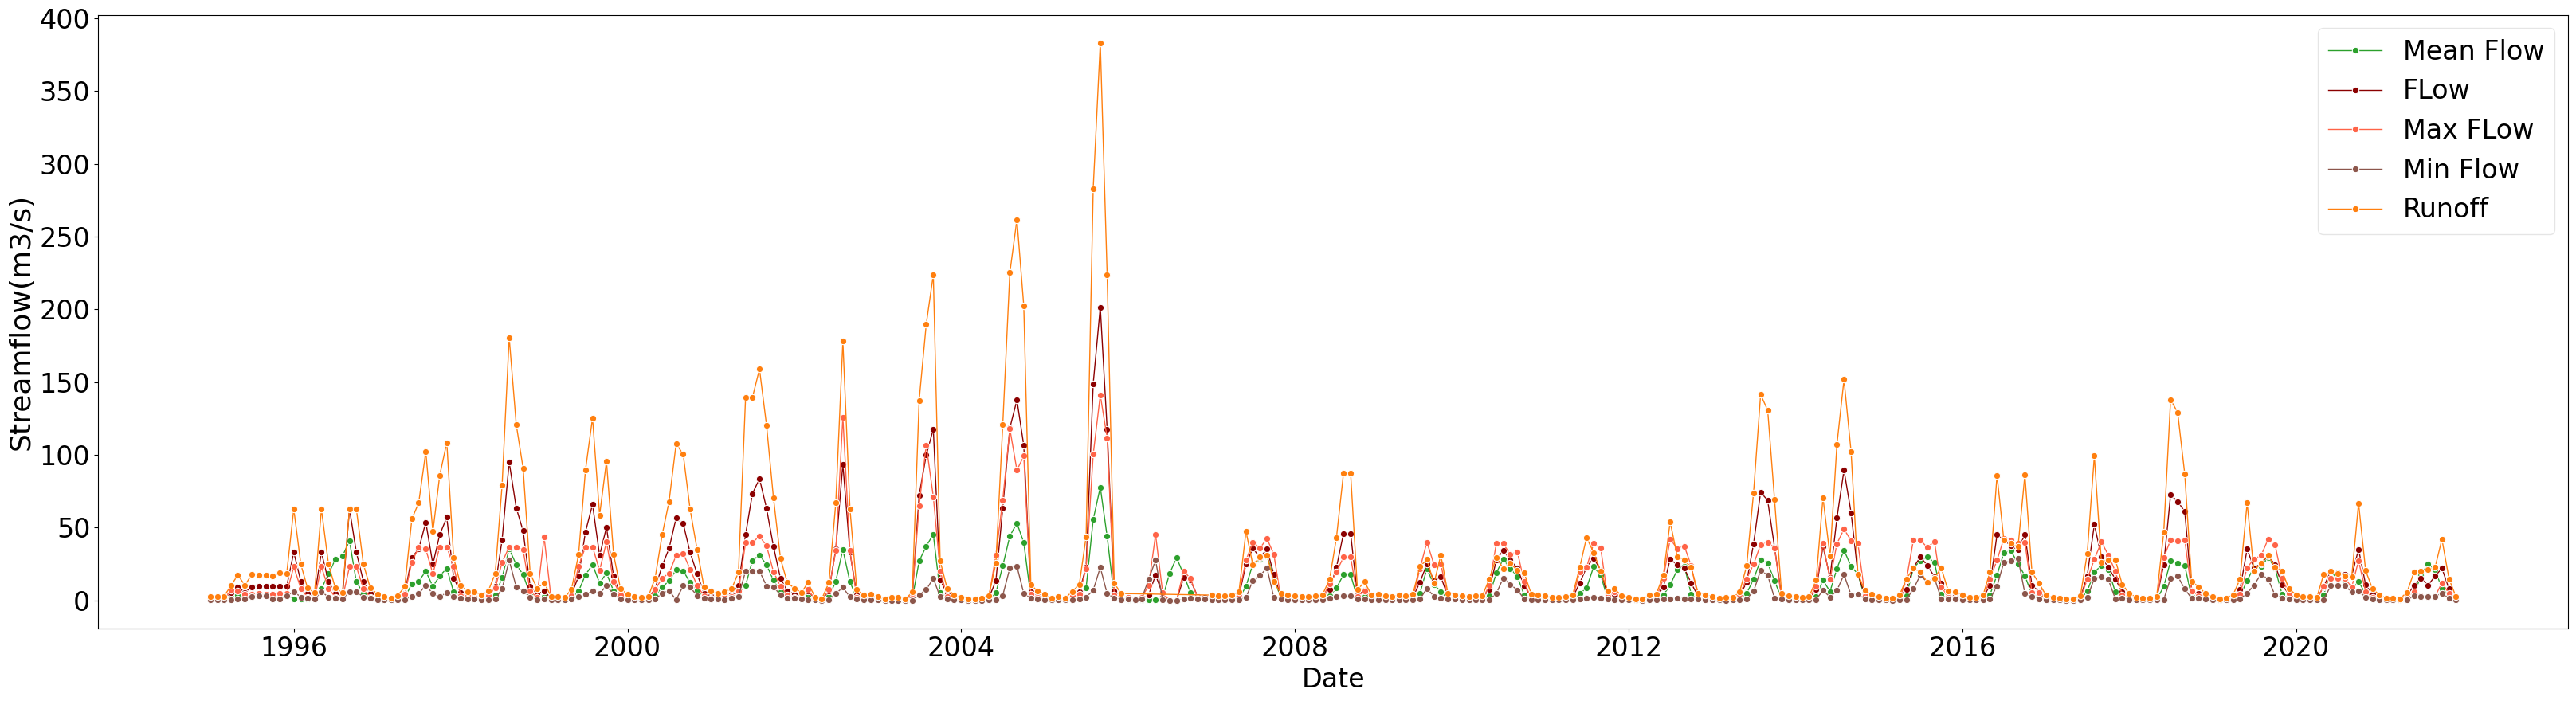

In [16]:
parameters = transformed_data['Parameter'].unique()

custom_colors = {
    parameters[0]: '#2ca02c',
    parameters[1]: '#8b0000',
    parameters[2]: '#ff6347',
    parameters[3]: '#8c564b',
    parameters[4]: '#ff7f0e',
}

plt.figure(figsize=(40, 10))

for parameter in parameters:
    parameter_data = transformed_data[transformed_data['Parameter'] == parameter]
    parameter_data.set_index('Date', inplace=True)
    sns.lineplot(data=parameter_data,
                 x=parameter_data.index,
                 y='Value',
                 marker='o',
                 label=parameter,
                 linewidth=1,
                 color=custom_colors[parameter])

# plt.title('Monthly Analysis', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Streamflow(m3/s)', fontsize=26)
plt.legend(loc='best', fontsize=24, framealpha=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [17]:
parameters = transformed_data['Parameter'].unique()
parameters

array(['Mean Flow', 'FLow', 'Max FLow', 'Min Flow', 'Runoff'],
      dtype=object)

## 5. FIND THE CORRELATIONS BETWEEN EACH PARAMETERS

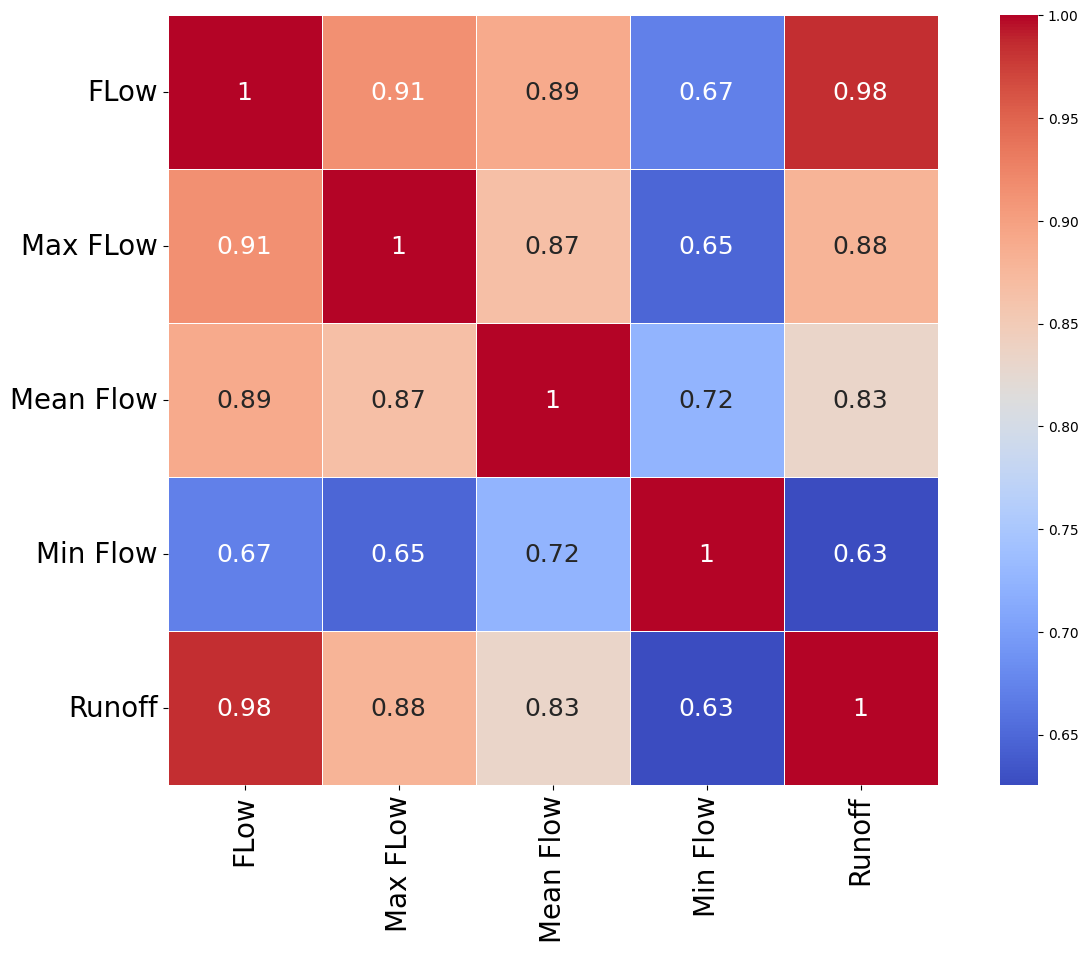

In [18]:
# Assuming transformed_data is already defined
pivot_data = transformed_data.pivot(index='Date', columns='Parameter', values='Value')
correlation_matrix = pivot_data.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, annot_kws={"size": 18})

# Adjust x-tick and y-tick labels rotation
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

plt.xlabel('')
plt.ylabel('')
plt.show()

## 6. COMMON FUNCTION

### TIME SERIES TO SUPERVISED

In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

### ADD ROLLING FEATURES

In [20]:
def add_rolling_features(data, window=3):
    df = pd.DataFrame(data)
    df['rolling_mean'] = df.iloc[:, 0].rolling(window=window).mean()
    df['rolling_std'] = df.iloc[:, 0].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

### TRAIN TEST SPLITT

In [21]:
def train_test_split(data, train_size=0.9):
    n_train = int(len(data) * train_size)
    return data[:n_train], data[n_train:]

### MEASURING METRICS

In [22]:
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
def willmotts_index(y_true, y_pred):
    return 1 - (np.sum((y_pred - y_true)**2) / np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true)))**2))


### CROSS VALIDATION AND MODEL EVALUATIONS

In [23]:
def walk_forward_validation(data, model):
    predictions = []
    train, test = train_test_split(data)
    history = [x for x in train.values]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1].values, test.iloc[i, -1]
        yhat = model(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i].values)
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    mae = mean_absolute_error(test.iloc[:, -1], predictions)
    rmse = np.sqrt(np.mean((test.iloc[:, -1] - np.asarray(predictions))**2))
    r2 = r2_score(test.iloc[:, -1], predictions)
    nse = nash_sutcliffe_efficiency(test.iloc[:, -1], predictions)
    willmott = willmotts_index(test.iloc[:, -1], predictions)
    return mae, rmse, r2, nse, willmott, test.index, test.iloc[:, -1], predictions

## 7. MODELS


### 1. RANDOM FOREST

In [24]:
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

### 2. SVM

In [25]:
from sklearn.svm import SVR
def svm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = SVR(kernel='rbf')
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 3. XGBRegressor

In [26]:
from xgboost import XGBRegressor
def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 4. LGBMRegressor


In [27]:
from lightgbm import LGBMRegressor
def lightgbm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = LGBMRegressor(n_estimators=50, verbose=-1)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


In [28]:
# Color dictionary for different models
colors_dict = {
    'LightGBM': '#27ad81',
    'XGBoost': '#5dc863',
    'SVM': '#aadc32',
    'Random Forest': '#fde725'
}

## 6. MEAN FLOW ANALYSIS

In [29]:
# Get the mean flow values
mean_flow = transformed_data[transformed_data['Parameter'] == parameters[0]]
mean_flow.head()

,Parameter,Date,Value
0,Mean Flow,1995-01-01,0.460
5,Mean Flow,1996-01-01,1.084
10,Mean Flow,1997-01-01,0.867
15,Mean Flow,1998-01-01,2.006
20,Mean Flow,1999-01-01,2.389


In [30]:
# drop the parameter columns
mean_flow = mean_flow.drop(columns=['Parameter'])

In [31]:
mean_flow.head()

,Date,Value
0,1995-01-01,0.460
5,1996-01-01,1.084
10,1997-01-01,0.867
15,1998-01-01,2.006
20,1999-01-01,2.389


In [32]:
# sort according to  the date
mean_flow= mean_flow.sort_values(by='Date')
mean_flow.head()

,Date,Value
0,1995-01-01,0.460
134,1995-02-01,0.555
268,1995-03-01,0.511
402,1995-04-01,2.048
536,1995-05-01,3.435


In [33]:
mean_flow.head()

,Date,Value
0,1995-01-01,0.460
134,1995-02-01,0.555
268,1995-03-01,0.511
402,1995-04-01,2.048
536,1995-05-01,3.435


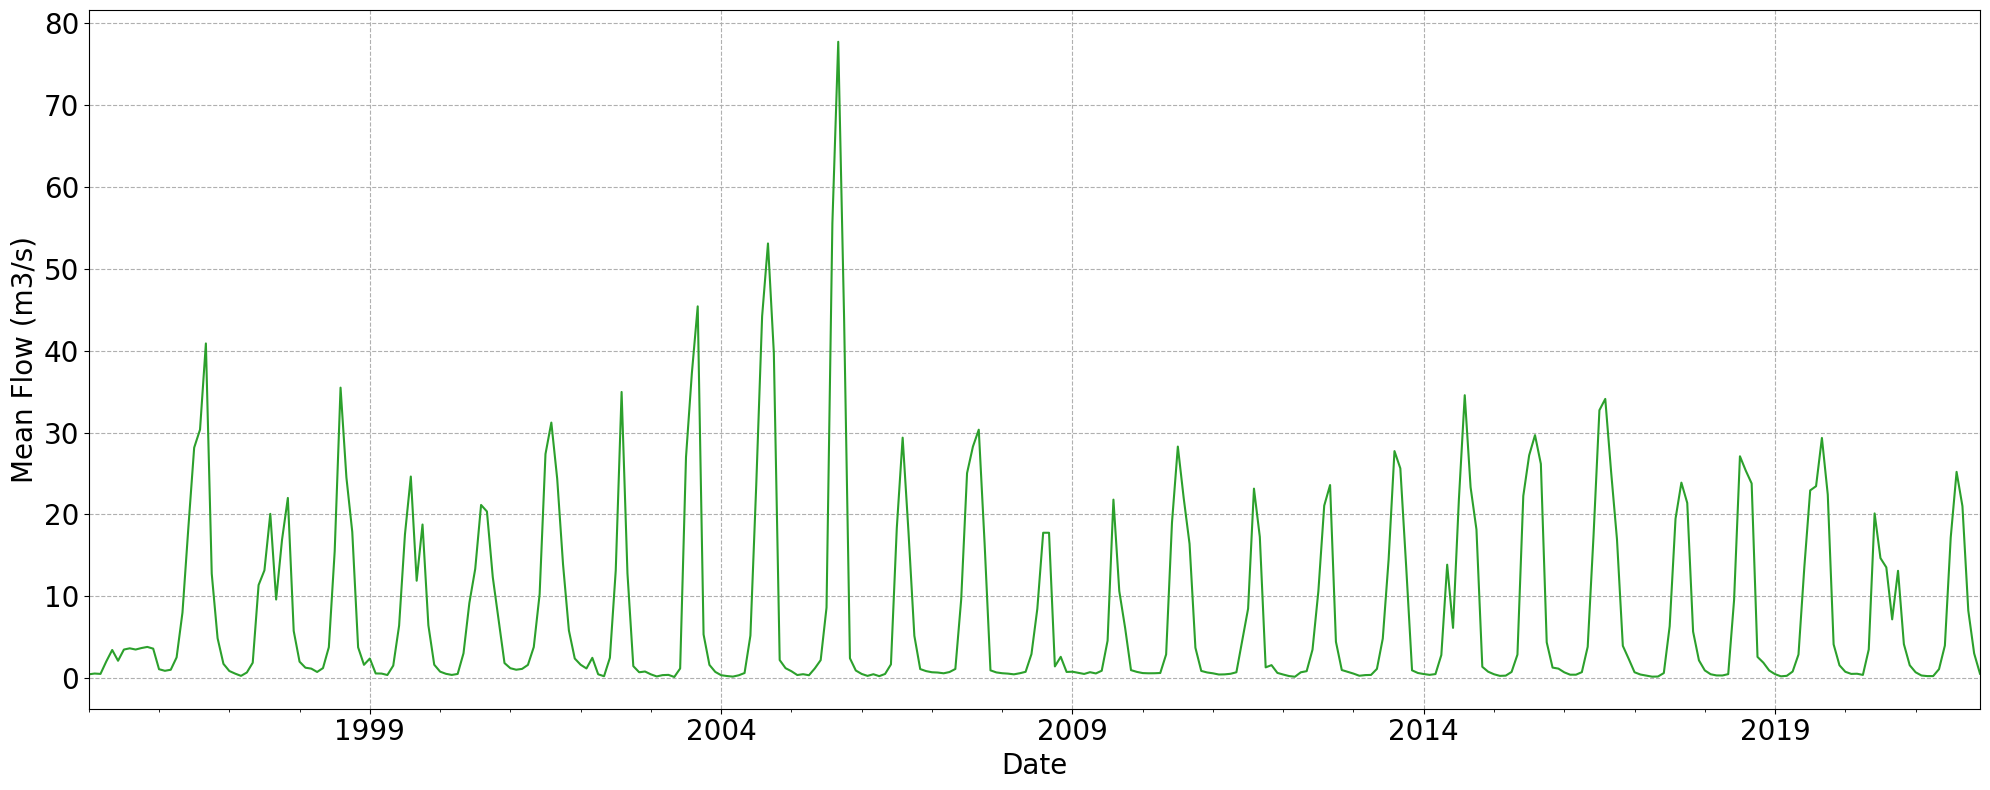

In [34]:
plt.figure(figsize=(20, 8))
mean_flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#2ca02c', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Mean Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [35]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [36]:
# H0: It is non stationary
# H1: It is stationary

In [37]:
adfuller_test(mean_flow['Value'])

ADF Test Statistic : -4.046217573308878
p-value : 0.001186928991902695
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [38]:
mean_flow = mean_flow[['Date', 'Value']]
mean_flow.set_index('Date', inplace=True)
mean_flow.head()

,Value
Date,
1995-01-01,0.460
1995-02-01,0.555
1995-03-01,0.511
1995-04-01,2.048
1995-05-01,3.435


In [39]:
model_names = []
mae_values = []
rmse_values = []
r2_values = []
nse_values = []
willmott_values = []

### TRAIN THE MODEL

In [40]:
# Assuming `mean flow` is your time series DataFrame
series = mean_flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.6, predicted=-0.6
>expected=0.3, predicted=0.4
>expected=0.8, predicted=0.8
>expected=0.1, predicted=0.2
>expected=-0.3, predicted=0.2
>expected=-0.2, predicted=0.2
>expected=1.3, predicted=1.3
>expected=1.1, predicted=1.2
>expected=-0.6, predicted=-0.6
>expected=-0.8, predicted=-0.9
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.6, predicted=-0.6
>expected=0.9, predicted=0.6
>expected=0.6, predicted=0.4
>expected=-0.3, predicted=0.2
>expected=-0.2, predicted=0.1
>expected=-0.3, predicted=0.2
>expected=-0.1, predicted=0.4
>expected=0.2, predicted=0.2
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.5, predicted=-0.5
>expected=0.6, predicted=0.5
>expected=0.9, predicted=1.1
>expected=-0.2, predicted=-0.0
>expected=0.6, predicted=-0.2
>expected=0.7, predicted=0.8
>expected=-0.2, predicted=-0.3
>expected=-0.6, predicted=-0.6
>expec

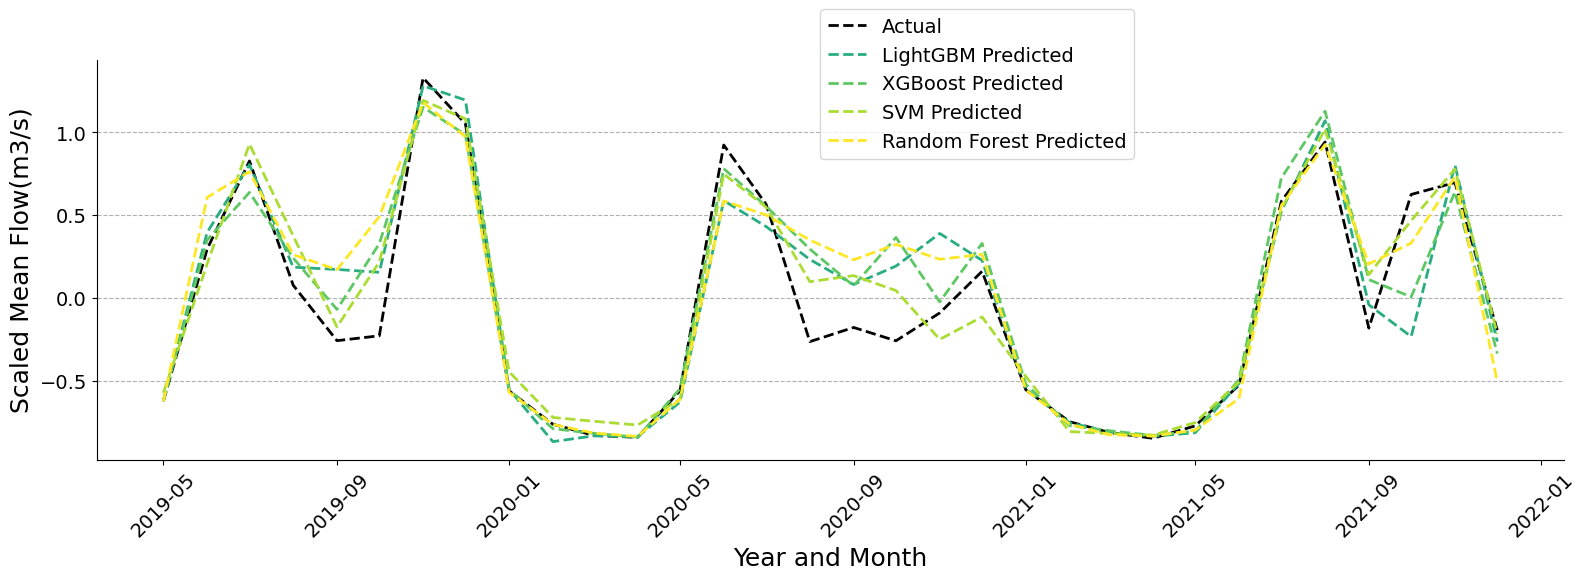

In [41]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



# Plot predictions for each model
for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Mean Flow(m3/s)', fontsize=18)
plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.6, 1.15), ncol=1)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [42]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [43]:
metrics

,Model,MAE,RMSE,R-squared,Nash-Sutcliffe Efficiency,Willmott's Index of Agreement
0,LightGBM,0.159064,0.254459,0.844434,0.844434,0.960785
1,XGBoost,0.152257,0.238392,0.863459,0.863459,0.964632
2,SVM,0.128908,0.174601,0.926756,0.926756,0.981072
3,Random Forest,0.193570,0.291132,0.796362,0.796362,0.948670


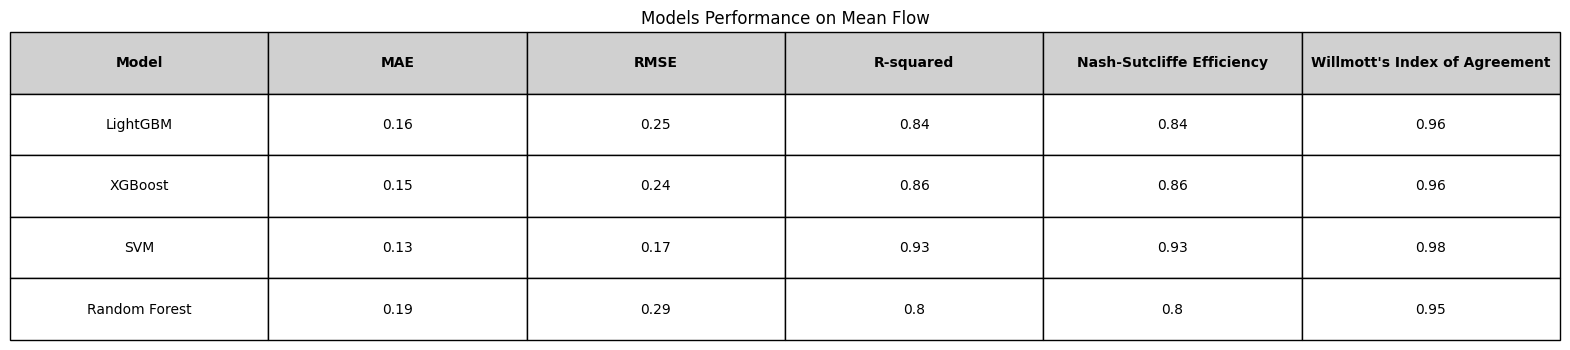

In [44]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Mean Flow')
plt.show()


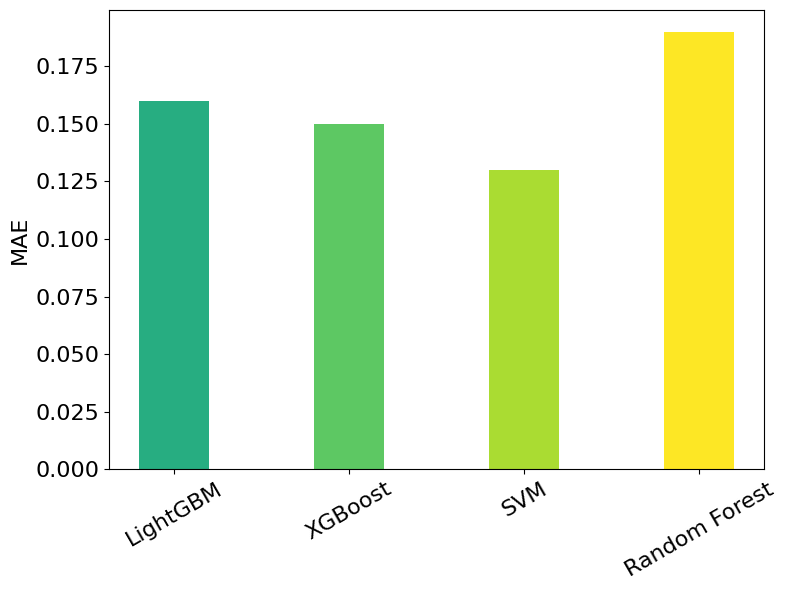

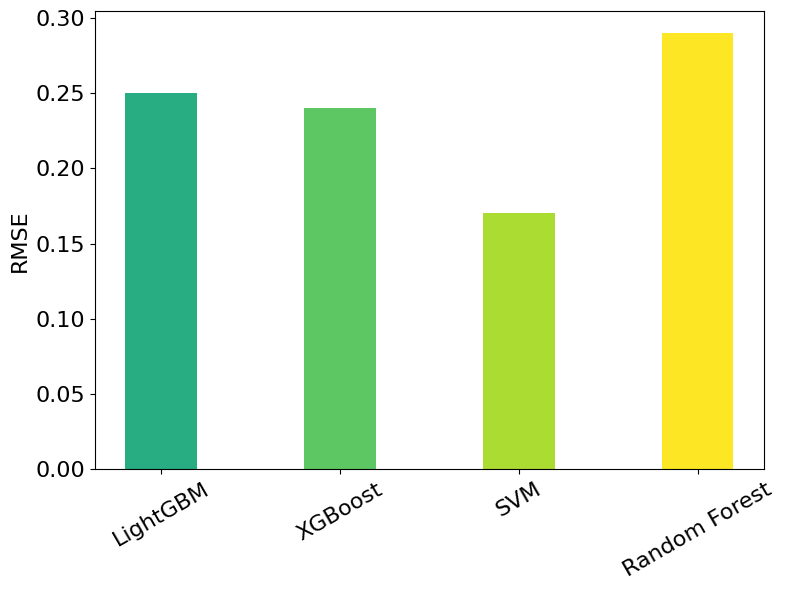

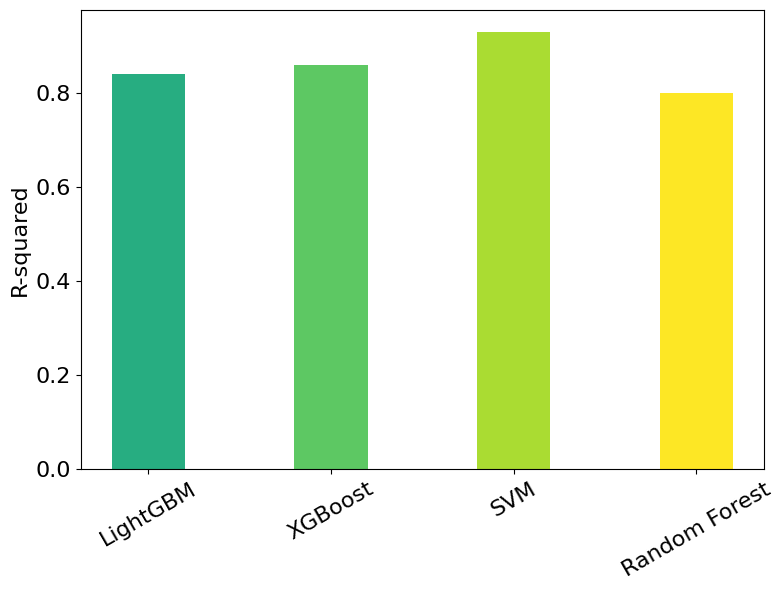

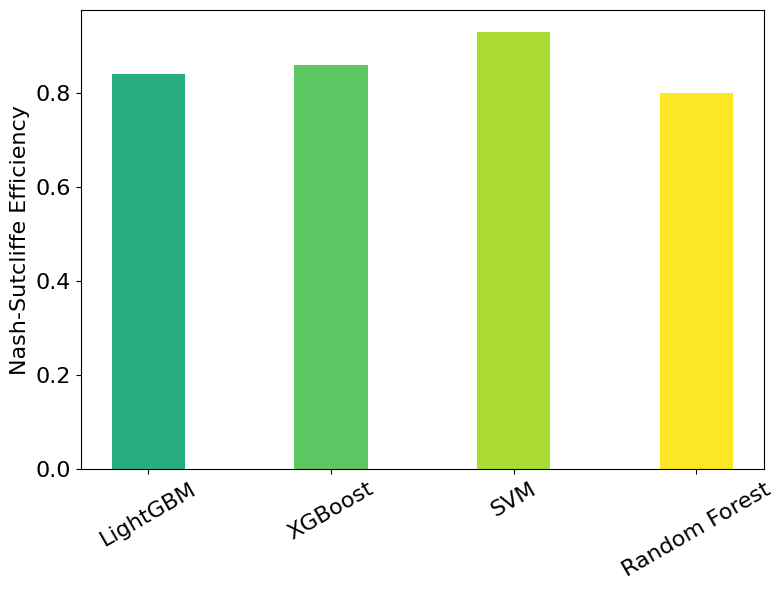

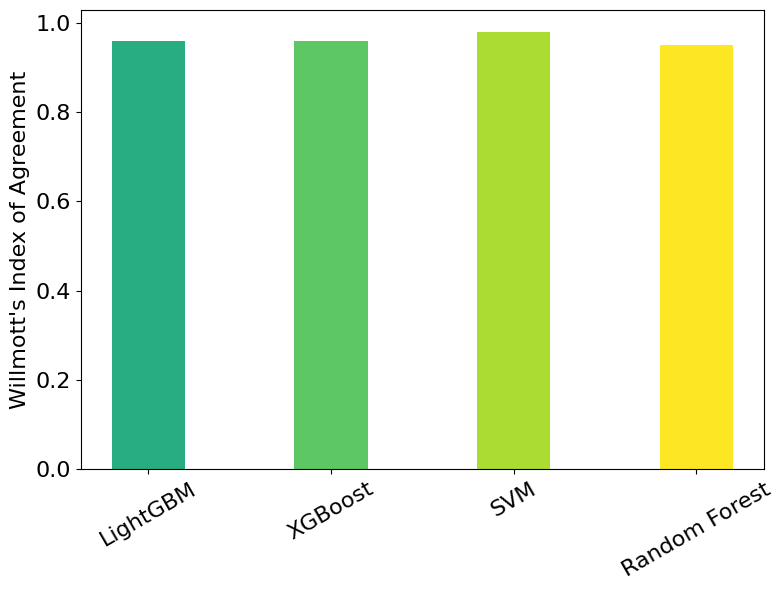

In [45]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()


## 7. FLOW ANALYSIS

In [46]:
# Get the temp_max values
flow = transformed_data[transformed_data['Parameter'] == parameters[1]]
flow.head()

,Parameter,Date,Value
1,FLow,1995-01-01,1.231
6,FLow,1996-01-01,33.074
11,FLow,1997-01-01,2.322
16,FLow,1998-01-01,5.372
21,FLow,1999-01-01,6.398


In [47]:
# drop the parameter columns
flow = flow.drop(columns=['Parameter'])

In [48]:
flow.head()

,Date,Value
1,1995-01-01,1.231
6,1996-01-01,33.074
11,1997-01-01,2.322
16,1998-01-01,5.372
21,1999-01-01,6.398


In [49]:
# sort according to  the date
flow= flow.sort_values(by='Date')
flow.head()

,Date,Value
1,1995-01-01,1.231
135,1995-02-01,1.343
269,1995-03-01,1.370
403,1995-04-01,5.309
537,1995-05-01,9.200


In [50]:
flow.head()

,Date,Value
1,1995-01-01,1.231
135,1995-02-01,1.343
269,1995-03-01,1.370
403,1995-04-01,5.309
537,1995-05-01,9.200


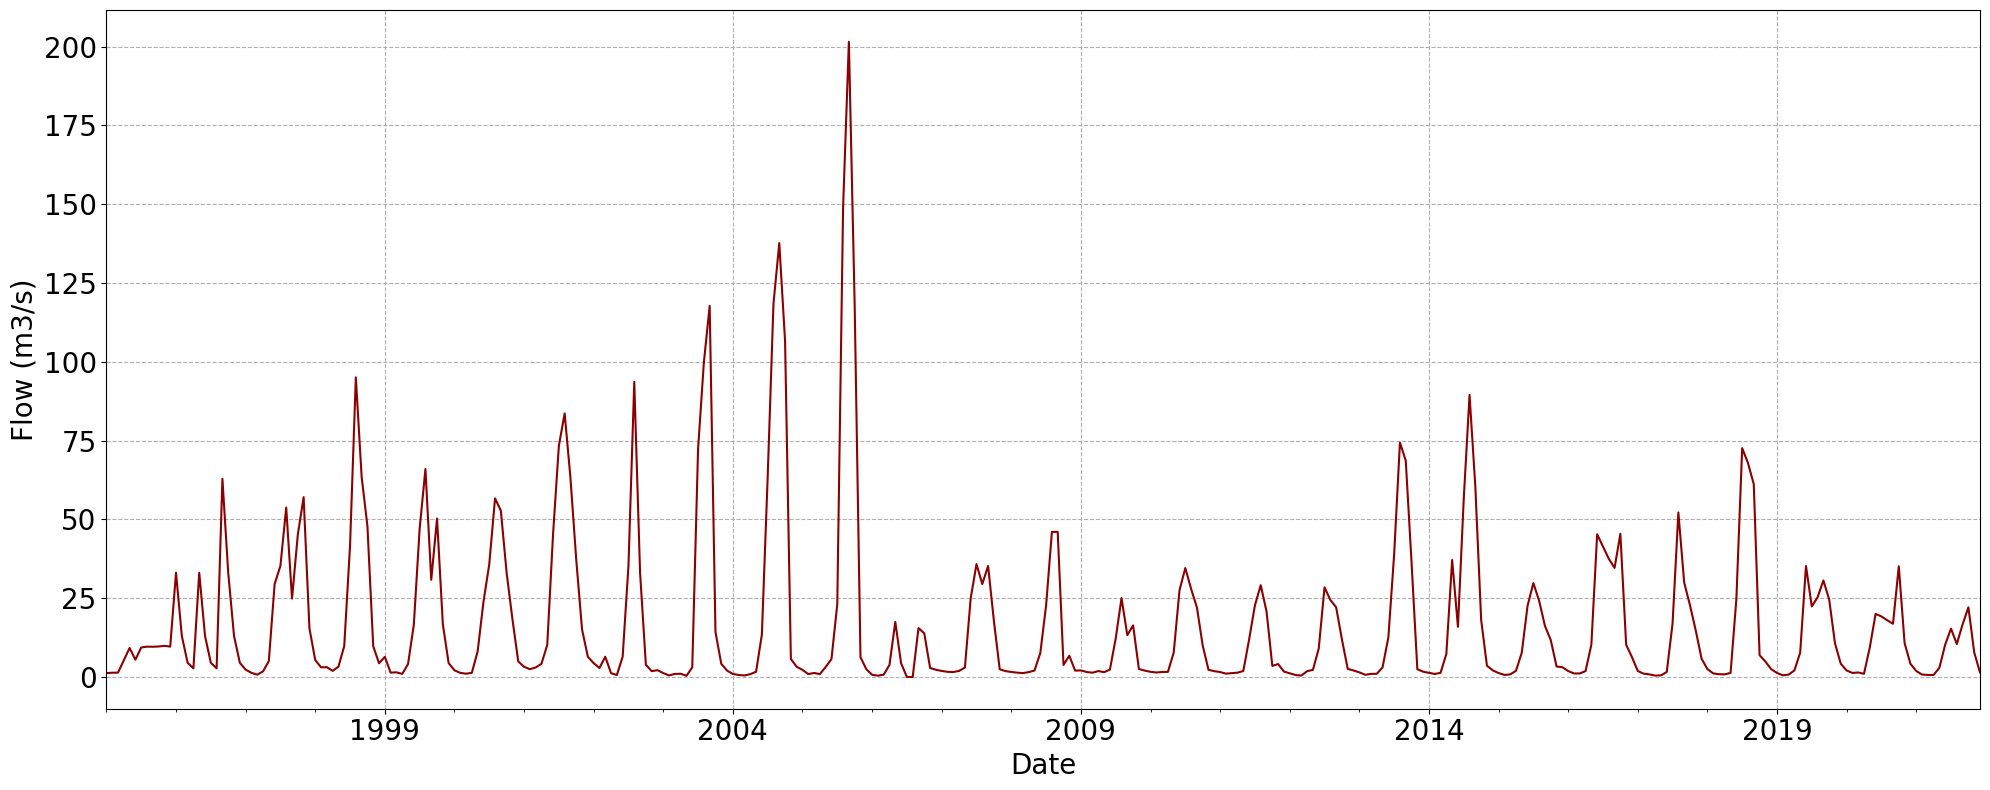

In [51]:

plt.figure(figsize=(20, 8))
flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8b0000', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [52]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [53]:
# H0: It is non stationary
# H1: It is stationary

In [54]:
adfuller_test(flow['Value'])

ADF Test Statistic : -3.1388896550094847
p-value : 0.023805869554636105
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [55]:
flow = flow[['Date', 'Value']]
flow.set_index('Date', inplace=True)
flow.head()

,Value
Date,
1995-01-01,1.231
1995-02-01,1.343
1995-03-01,1.370
1995-04-01,5.309
1995-05-01,9.200


In [56]:
flow_model_names = []
flow_mae_values = []
flow_rmse_values = []
flow_r2_values = []
flow_nse_values = []
flow_willmott_values = []

### TRAIN THE MODELS

In [57]:
# Assuming `temp_max` is your time series DataFrame
series = flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.5, predicted=-0.5
>expected=0.5, predicted=0.4
>expected=0.2, predicted=0.2
>expected=-0.3, predicted=0.2
>expected=-0.5, predicted=-0.2
>expected=-0.5, predicted=-0.1
>expected=-0.0, predicted=0.2
>expected=-0.0, predicted=0.2
>expected=-0.4, predicted=-0.4
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.4, predicted=-0.5
>expected=-0.1, predicted=-0.2
>expected=-0.3, predicted=-0.0
>expected=-0.7, predicted=-0.0
>expected=-0.7, predicted=-0.3
>expected=-0.0, predicted=-0.2
>expected=0.1, predicted=-0.1
>expected=0.4, predicted=0.2
>expected=-0.4, predicted=-0.3
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.4, predicted=-0.4
>expected=-0.3, predicted=-0.2
>expected=-0.5, predicted=-0.2
>expected=-0.5, predicted=-0.4
>expected=-0.3, predicted=-0.4
>expected=-0.2, predicted=0.0
>expected=-0.0, predicted=-0.1
>expected=-0.5, pre

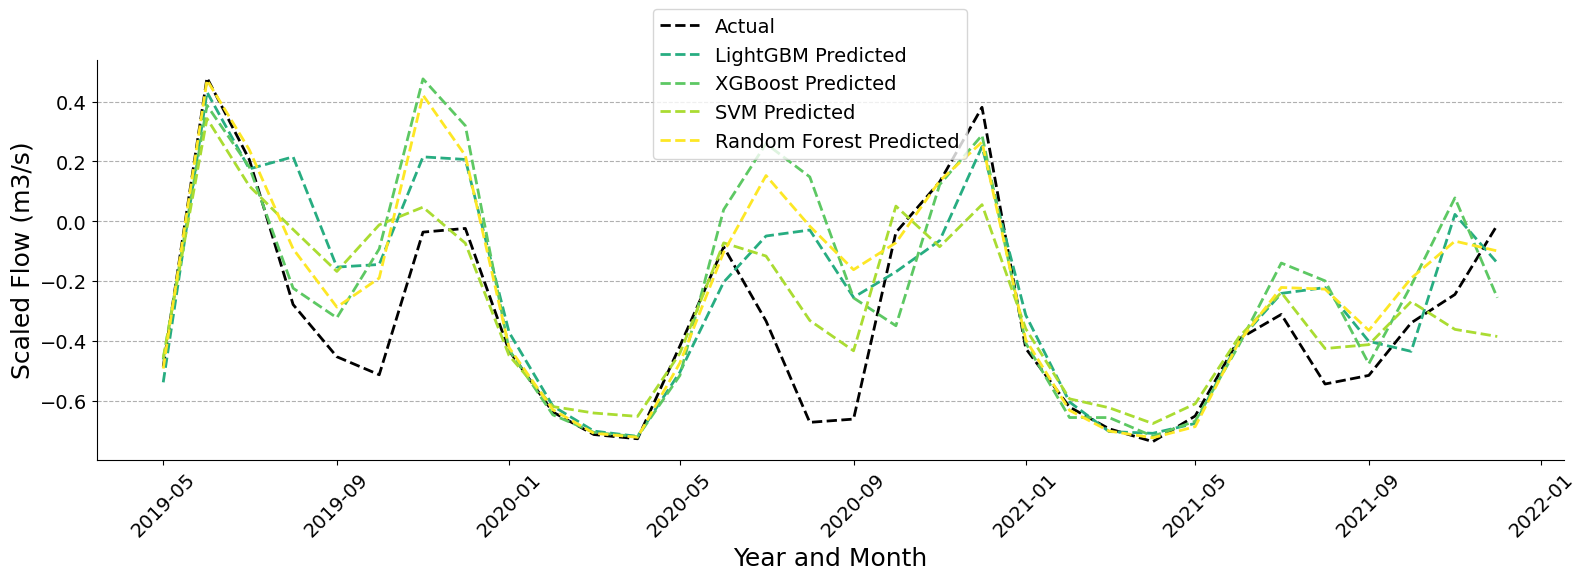

In [58]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [59]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [60]:
metrics

,Model,MAE,RMSE,R-squared,Nash-Sutcliffe Efficiency,Willmott's Index of Agreement
0,LightGBM,0.158344,0.222436,0.533140,0.533140,0.880003
1,XGBoost,0.171128,0.264562,0.339568,0.339568,0.846199
2,SVM,0.130814,0.178804,0.698332,0.698332,0.904694
3,Random Forest,0.146455,0.231957,0.492320,0.492320,0.885462


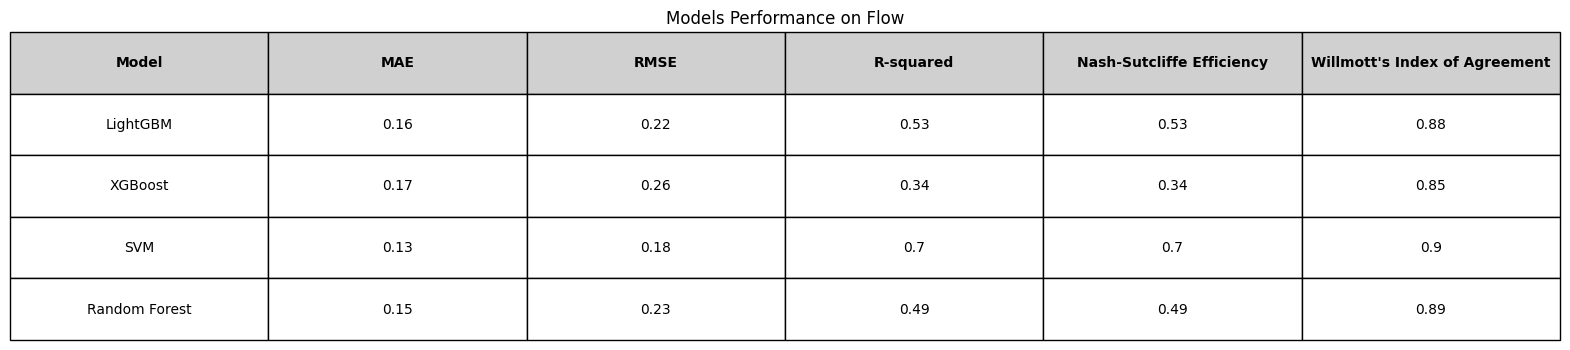

In [61]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Flow')
plt.show()


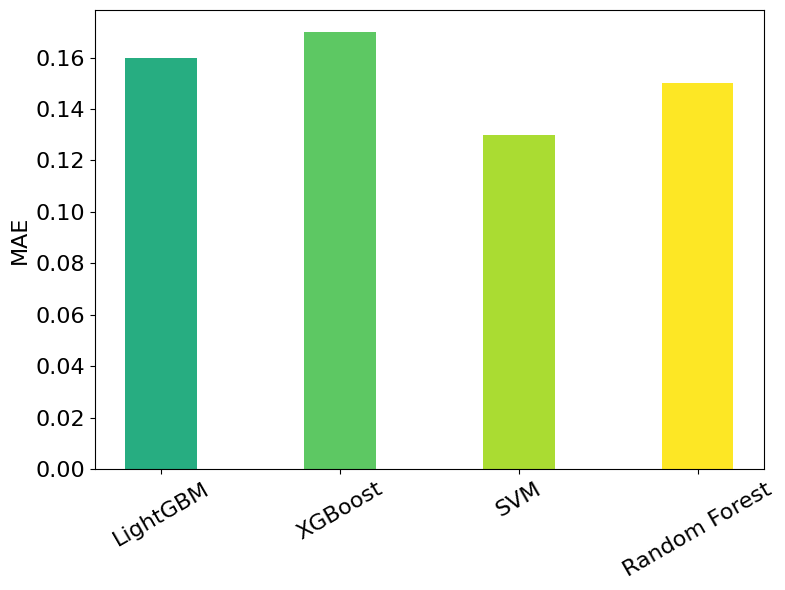

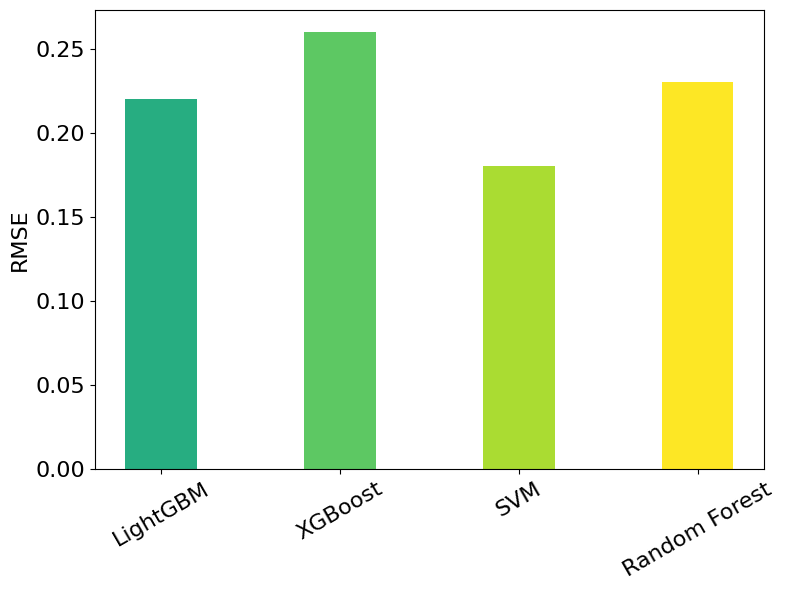

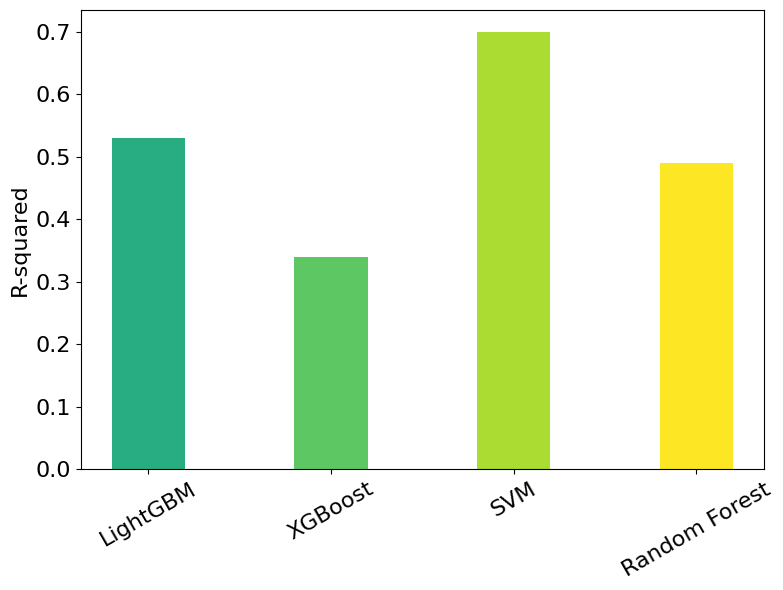

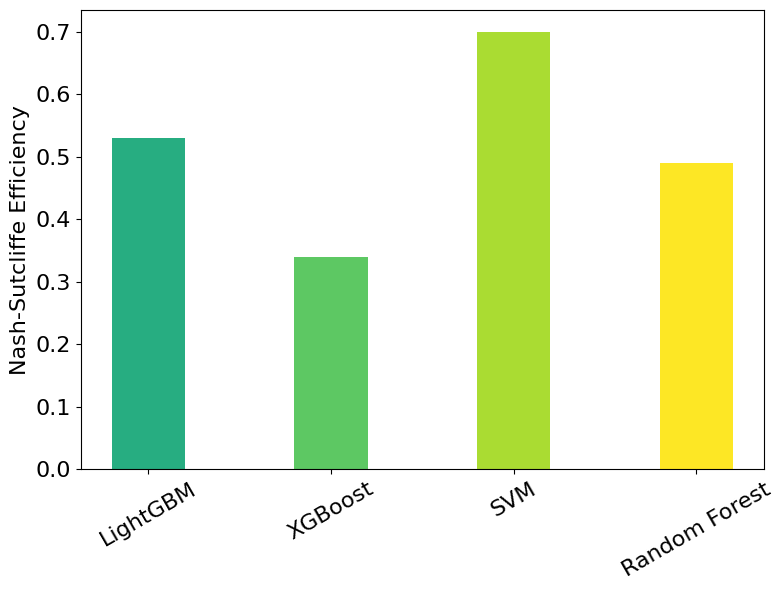

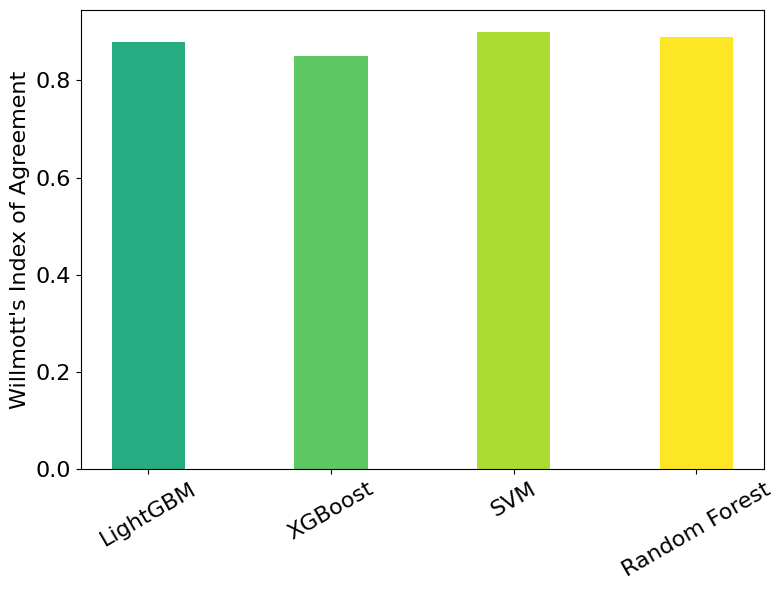

In [62]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 8. MAX FLOW ANALYSIS

In [63]:
# Get the temp_max values
flow_max = transformed_data[transformed_data['Parameter'] == parameters[2]]
flow_max.head()

,Parameter,Date,Value
2,Max FLow,1995-01-01,0.593
7,Max FLow,1996-01-01,23.131
12,Max FLow,1997-01-01,1.358
17,Max FLow,1998-01-01,3.377
22,Max FLow,1999-01-01,43.585


In [64]:
# drop the parameter columns
flow_max = flow_max.drop(columns=['Parameter'])

In [65]:
flow_max.head()

,Date,Value
2,1995-01-01,0.593
7,1996-01-01,23.131
12,1997-01-01,1.358
17,1998-01-01,3.377
22,1999-01-01,43.585


In [66]:
# sort according to  the date
flow_max= flow_max.sort_values(by='Date')
flow_max.head()

,Date,Value
2,1995-01-01,0.593
136,1995-02-01,0.722
270,1995-03-01,1.002
404,1995-04-01,6.966
538,1995-05-01,6.306


In [67]:
flow_max.head()

,Date,Value
2,1995-01-01,0.593
136,1995-02-01,0.722
270,1995-03-01,1.002
404,1995-04-01,6.966
538,1995-05-01,6.306


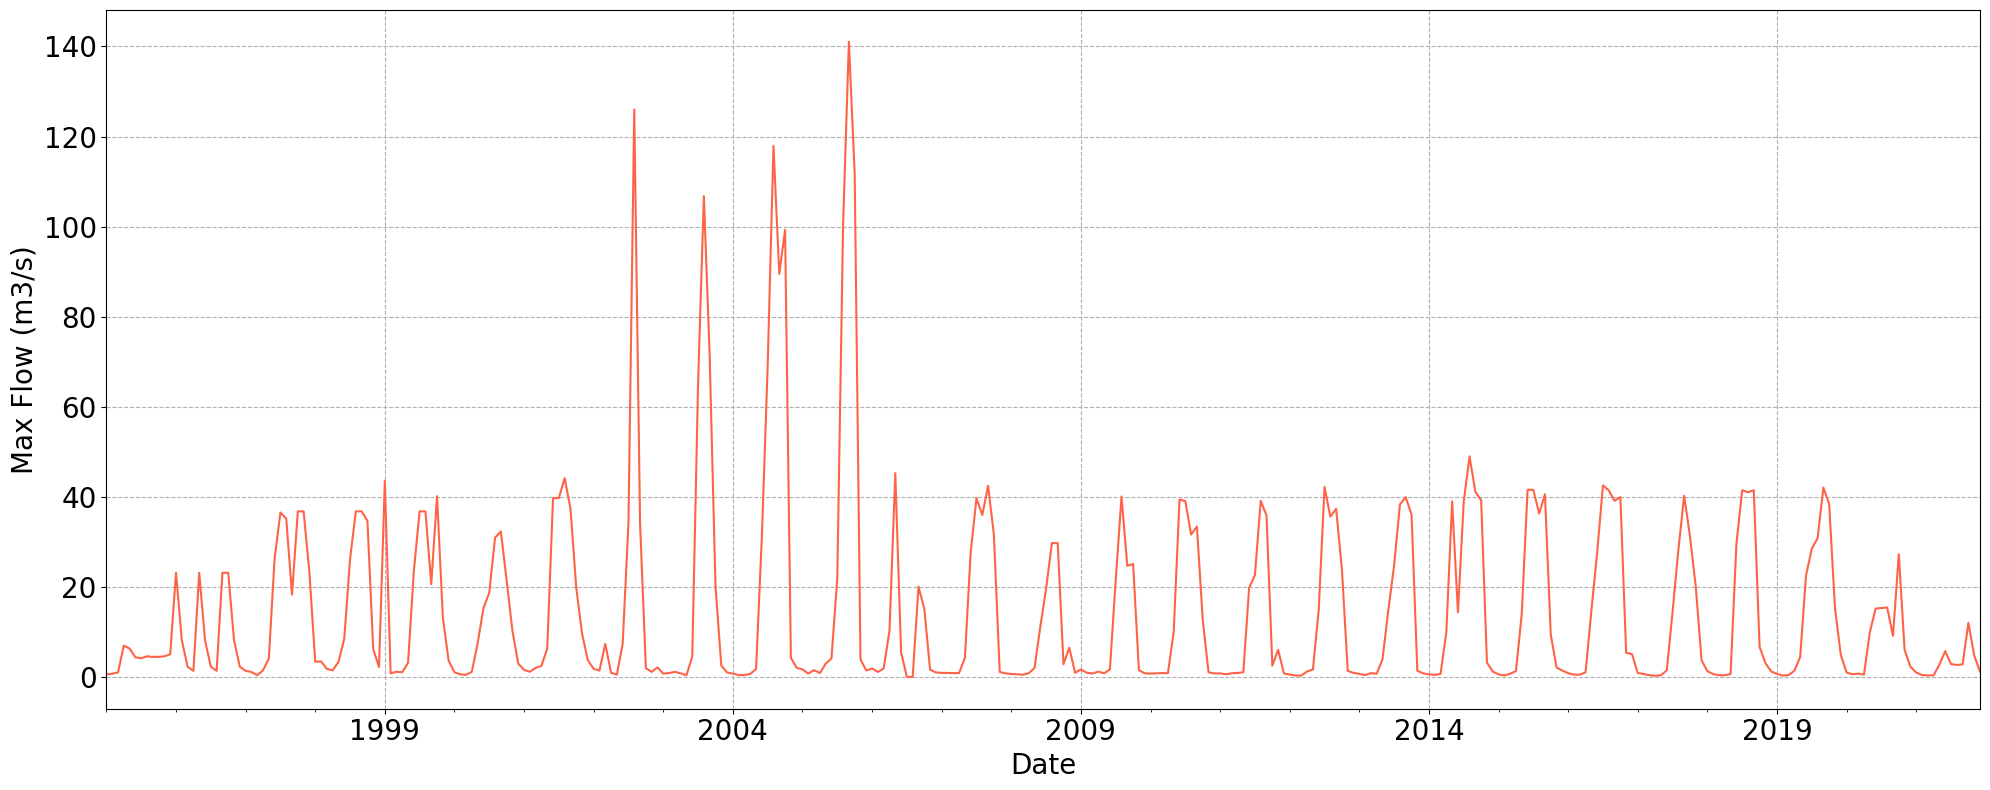

In [68]:
plt.figure(figsize=(20, 8))
flow_max.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff6347', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Max Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [69]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [70]:
# H0: It is non stationary
# H1: It is stationary

In [71]:
adfuller_test(flow_max['Value'])

ADF Test Statistic : -2.792227314758844
p-value : 0.05939264708899431
#Lags Used : 11
Number of Observations Used : 312
Weak evidence against the null hypothesis(H0)


In [72]:
flow_max = flow_max[['Date', 'Value']]
flow_max.set_index('Date', inplace=True)
flow_max.head()

,Value
Date,
1995-01-01,0.593
1995-02-01,0.722
1995-03-01,1.002
1995-04-01,6.966
1995-05-01,6.306


In [73]:
flow_max_model_names = []
flow_max_mae_values = []
flow_max_rmse_values = []
flow_max_r2_values = []
flow_max_nse_values = []
flow_max_willmott_values = []

### TRAIN THE MODEL

In [74]:
# Assuming `flow_max` is your time series DataFrame
series = flow_max
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.6, predicted=-0.6
>expected=0.2, predicted=0.3
>expected=0.3, predicted=0.3
>expected=-0.4, predicted=-0.1
>expected=-0.2, predicted=-0.0
>expected=-0.3, predicted=0.8
>expected=0.4, predicted=0.1
>expected=0.7, predicted=0.7
>expected=-0.1, predicted=-0.1
>expected=-0.6, predicted=-0.6
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.8
>expected=-0.3, predicted=-0.4
>expected=-0.1, predicted=0.2
>expected=-0.5, predicted=-0.0
>expected=-0.8, predicted=-0.0
>expected=-0.5, predicted=-0.1
>expected=0.0, predicted=0.2
>expected=0.2, predicted=0.1
>expected=0.4, predicted=0.1
>expected=-0.5, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.8, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.5, predicted=-0.6
>expected=-0.6, predicted=-0.5
>expected=-0.6, predicted=-0.5
>expected=-0.8, predicted=-0.7
>expected=-0.3, predicted=-0.2
>expected=-0.4, predicted=-0.2
>expected=-0.3, predicted=-0.3
>expected=-0.6, predicte

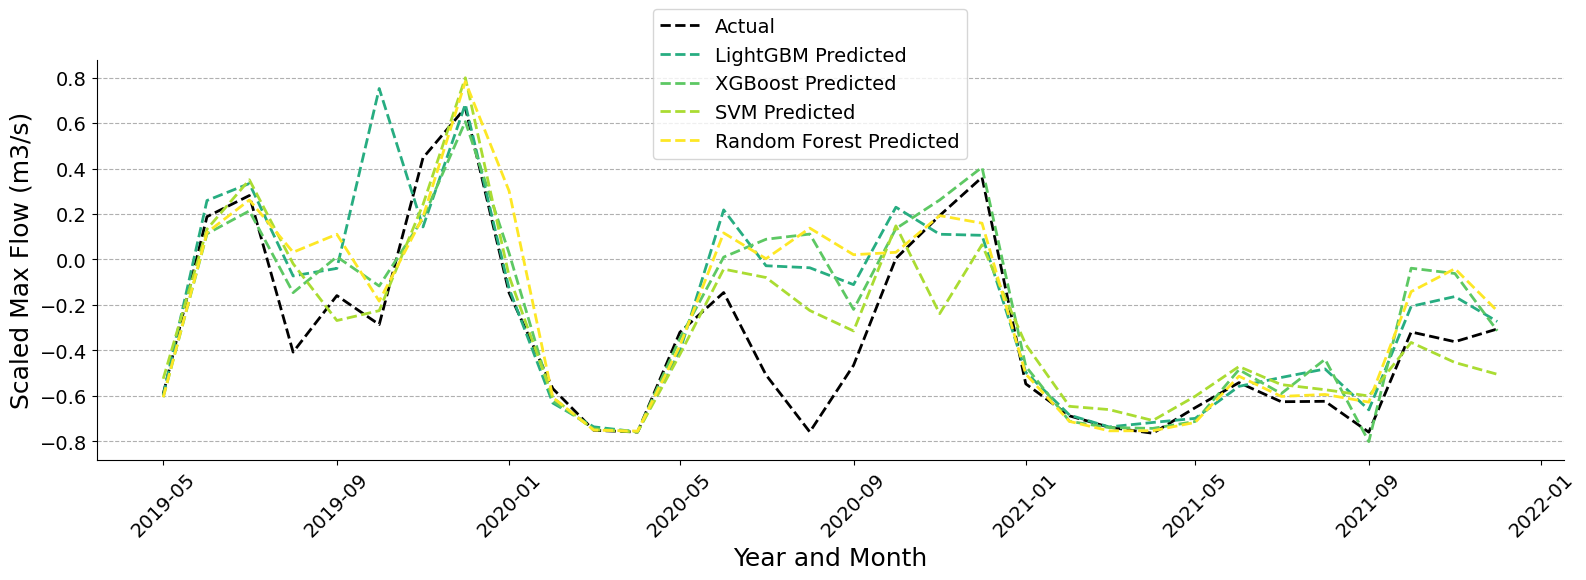

In [75]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Max Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [76]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [77]:
metrics

,Model,MAE,RMSE,R-squared,Nash-Sutcliffe Efficiency,Willmott's Index of Agreement
0,LightGBM,0.170838,0.282477,0.486516,0.486516,0.874883
1,XGBoost,0.142425,0.229764,0.660276,0.660276,0.915196
2,SVM,0.140103,0.192508,0.761515,0.761515,0.932628
3,Random Forest,0.151488,0.244824,0.614283,0.614283,0.906754


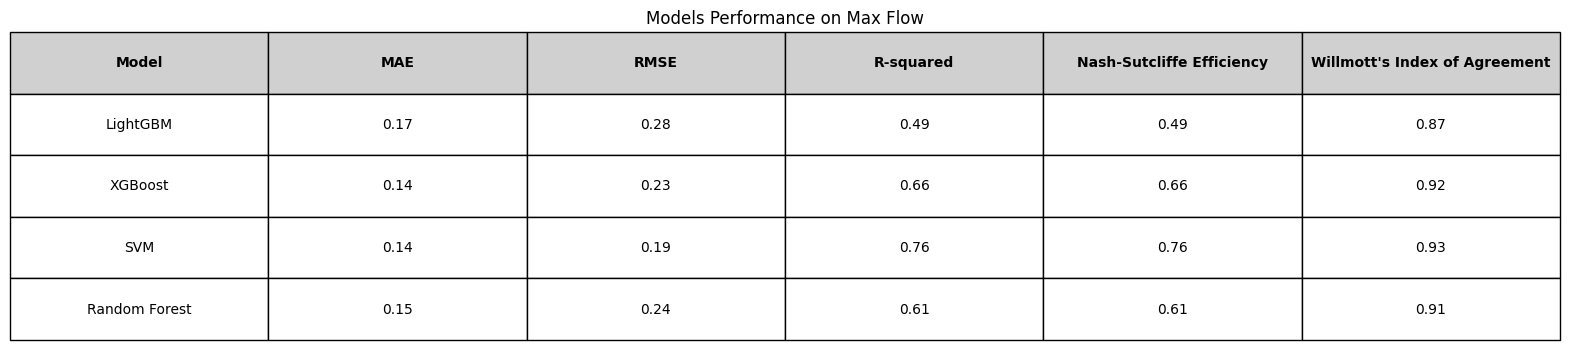

In [78]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Max Flow')
plt.show()


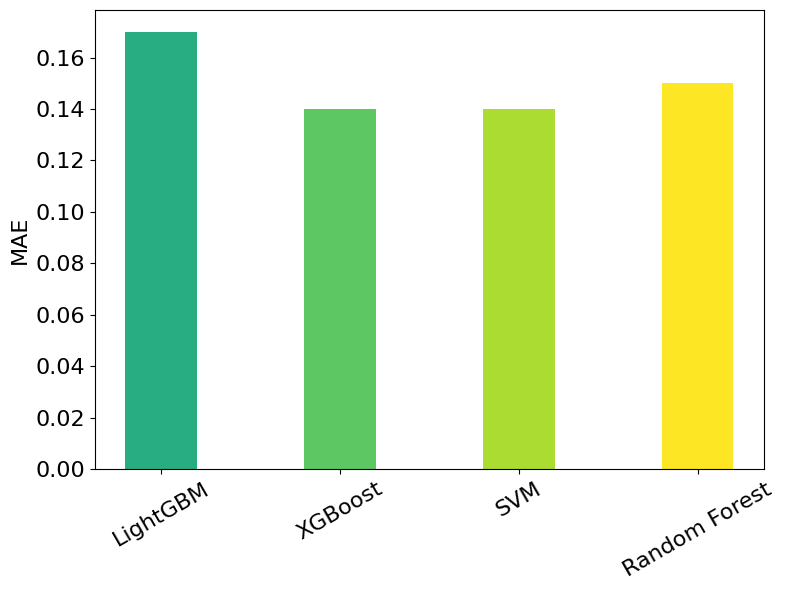

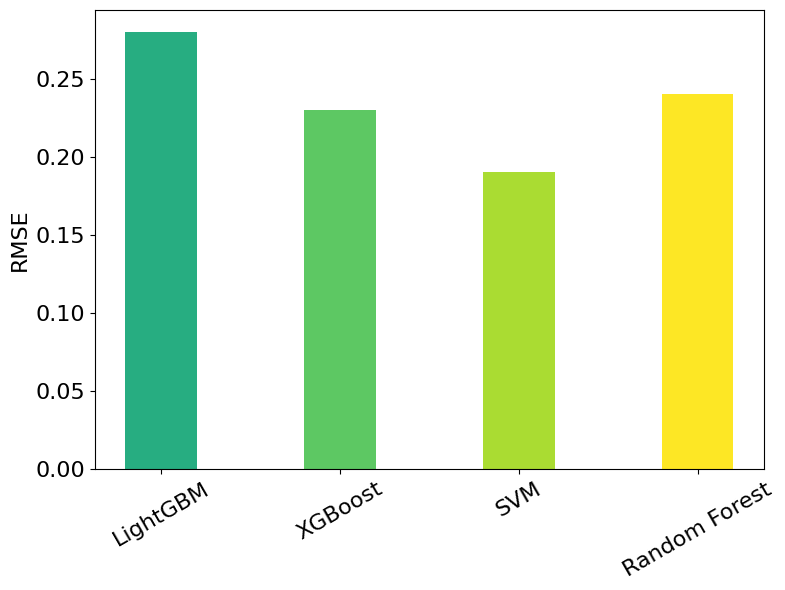

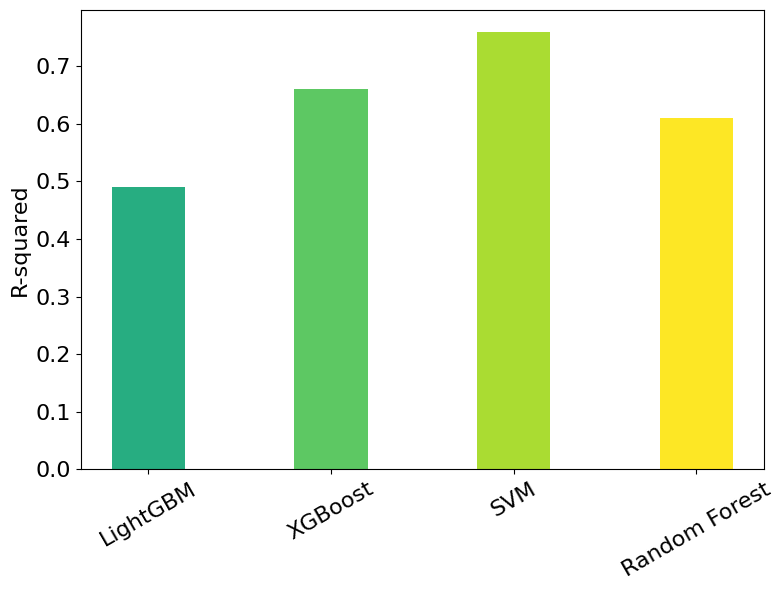

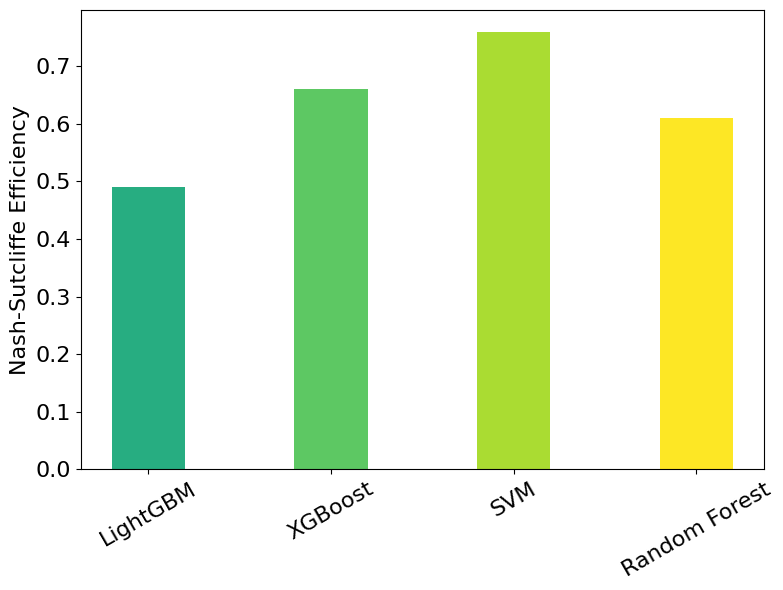

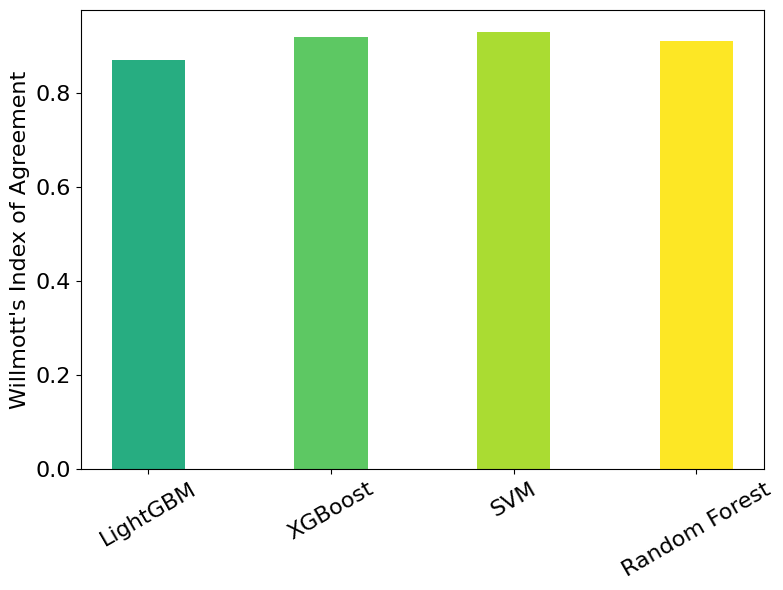

In [79]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 9. MIN FLOW ANALYSIS

In [80]:
flow_min = transformed_data[transformed_data['Parameter']=='Min Flow']

In [81]:
# drop the parameter columns
flow_min = flow_min.drop(columns=['Parameter'])

In [82]:
flow_min.head()

,Date,Value
3,1995-01-01,0.356
8,1996-01-01,5.983
13,1997-01-01,0.593
18,1998-01-01,1.254
23,1999-01-01,0.813


In [83]:
# sort according to  the date
flow_min = flow_min.sort_values(by='Date')
flow_min.head()

,Date,Value
3,1995-01-01,0.356
137,1995-02-01,0.470
271,1995-03-01,0.286
405,1995-04-01,0.286
539,1995-05-01,1.202


In [84]:
flow_min.head()

,Date,Value
3,1995-01-01,0.356
137,1995-02-01,0.470
271,1995-03-01,0.286
405,1995-04-01,0.286
539,1995-05-01,1.202


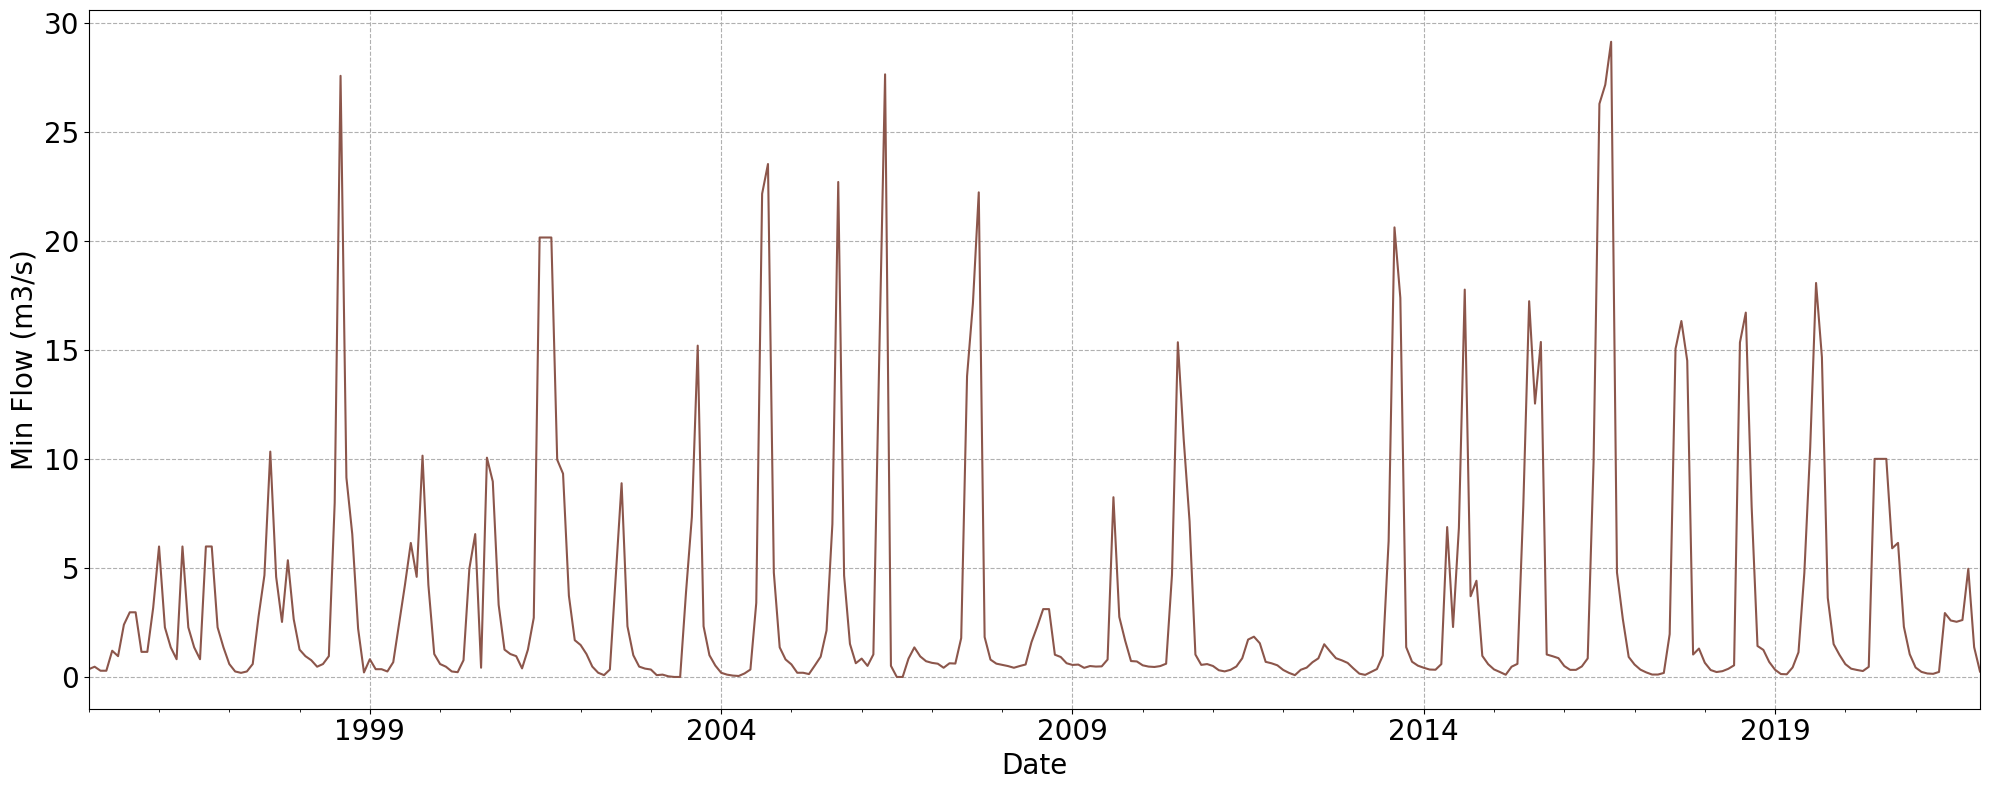

In [85]:
plt.figure(figsize=(20, 8))
flow_min.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8c564b', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Min Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [86]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [87]:
# H0: It is non stationary
# H1: It is stationary

In [88]:
adfuller_test(flow_min['Value'])

ADF Test Statistic : -3.9056974671331663
p-value : 0.0019933147027447386
#Lags Used : 11
Number of Observations Used : 312
Strong evidence against the null hypothesis(H0)


In [89]:
flow_min = flow_min[['Date', 'Value']]
flow_min.set_index('Date', inplace=True)
flow_min.head()

,Value
Date,
1995-01-01,0.356
1995-02-01,0.470
1995-03-01,0.286
1995-04-01,0.286
1995-05-01,1.202


In [90]:
flow_min_model_names = []
flow_min_mae_values = []
flow_min_rmse_values = []
flow_min_r2_values = []
flow_min_nse_values = []
flow_min_willmott_values = []

### TRAIN THE MODEL

In [91]:
# Assuming `flow min` is your time series DataFrame
series = flow_min
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.6, predicted=-0.6
>expected=-0.0, predicted=0.0
>expected=0.7, predicted=1.1
>expected=1.2, predicted=1.6
>expected=0.4, predicted=0.4
>expected=1.5, predicted=1.5
>expected=1.3, predicted=1.0
>expected=-0.3, predicted=-0.4
>expected=-0.6, predicted=-0.6
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=0.9, predicted=0.7
>expected=0.9, predicted=1.1
>expected=-0.7, predicted=1.3
>expected=-0.0, predicted=0.9
>expected=-0.1, predicted=0.4
>expected=-0.1, predicted=-0.2
>expected=0.1, predicted=0.1
>expected=-0.4, predicted=-0.4
>expected=-0.6, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.3, predicted=-0.4
>expected=-0.3, predicted=-0.2
>expected=-0.7, predicted=-0.3
>expected=-0.7, predicted=-0.4
>expected=-0.3, predicted=-0.1
>expected=-0.2, predicted=-0.2
>expected=-0.0, predicted=-0.3
>expected=-0.6, predicted=-0

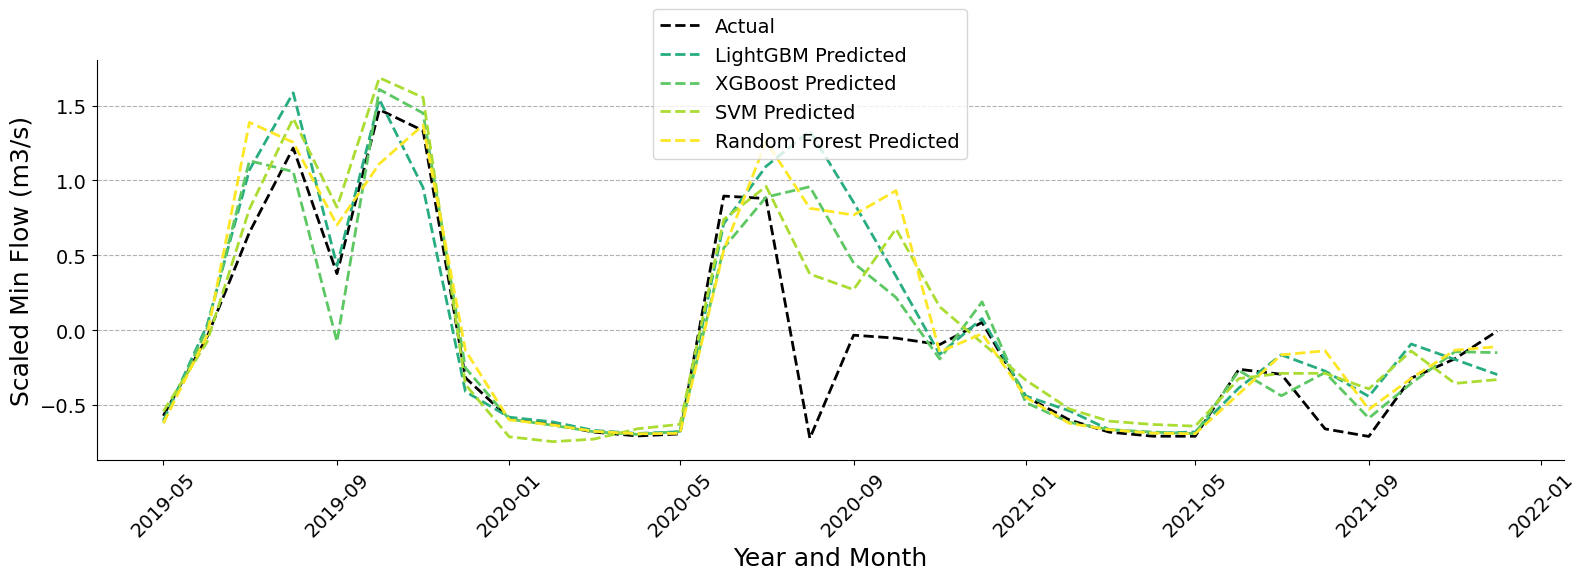

In [92]:
# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Min Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [93]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [94]:
metrics

,Model,MAE,RMSE,R-squared,Nash-Sutcliffe Efficiency,Willmott's Index of Agreement
0,LightGBM,0.217350,0.437233,0.546804,0.546804,0.896036
1,XGBoost,0.174098,0.352609,0.705255,0.705255,0.928531
2,SVM,0.197488,0.294435,0.794487,0.794487,0.952273
3,Random Forest,0.234018,0.418015,0.585768,0.585768,0.906890


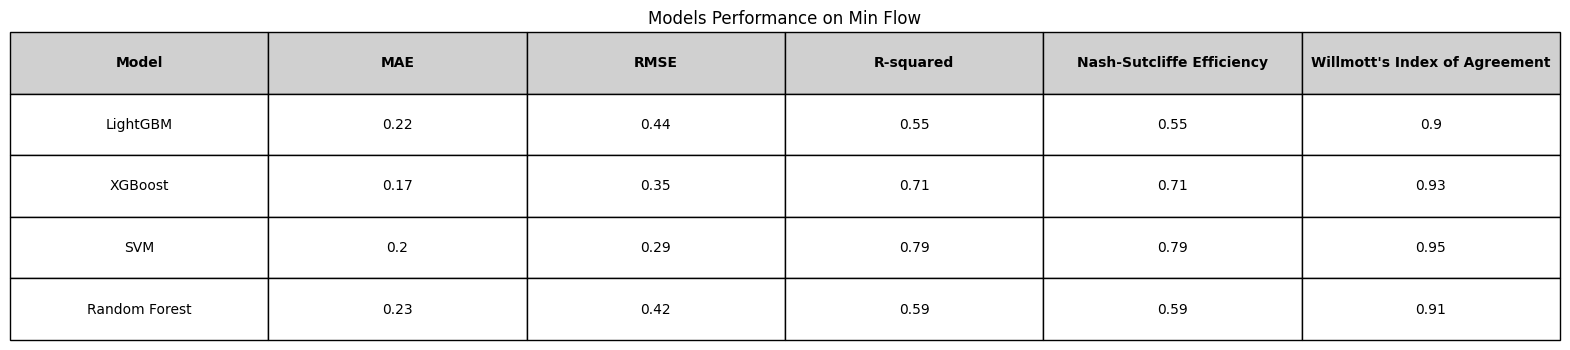

In [95]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Min Flow')
plt.show()


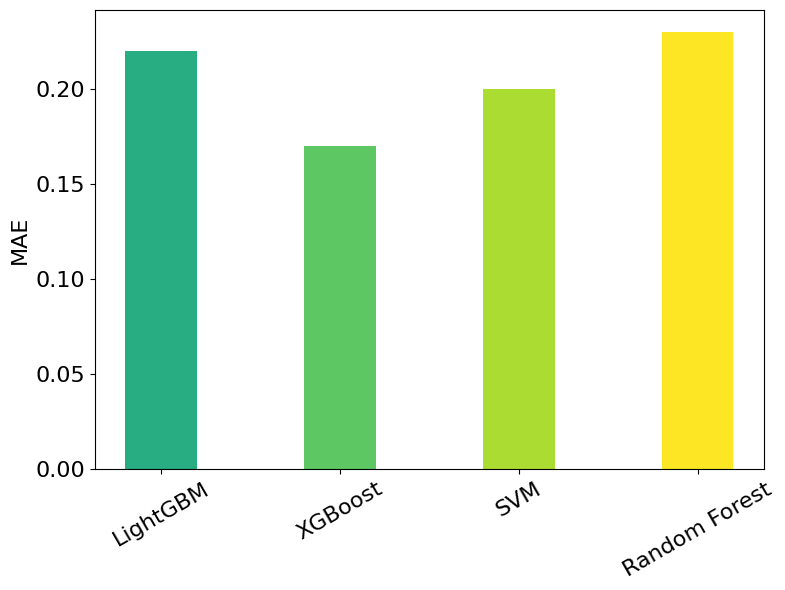

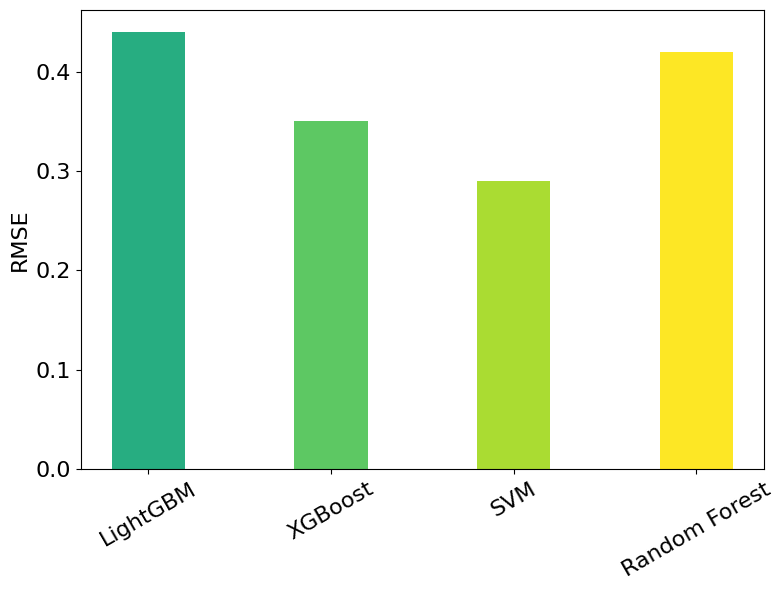

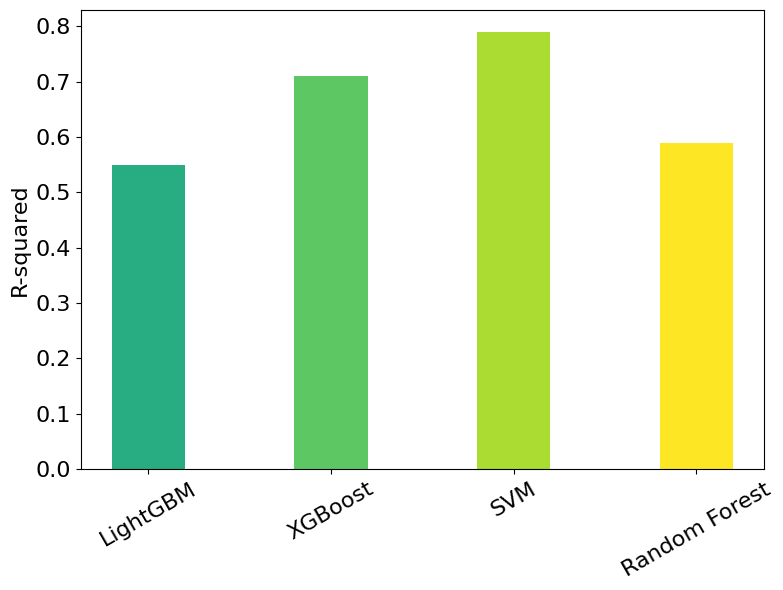

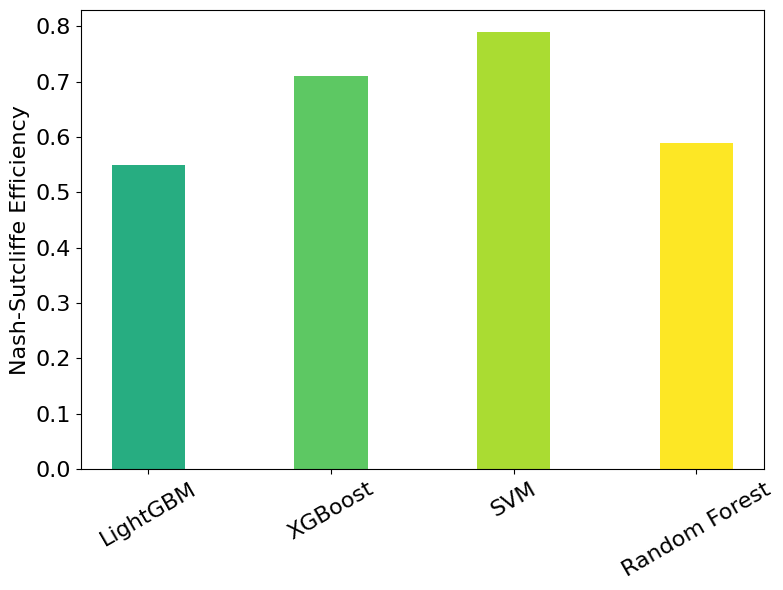

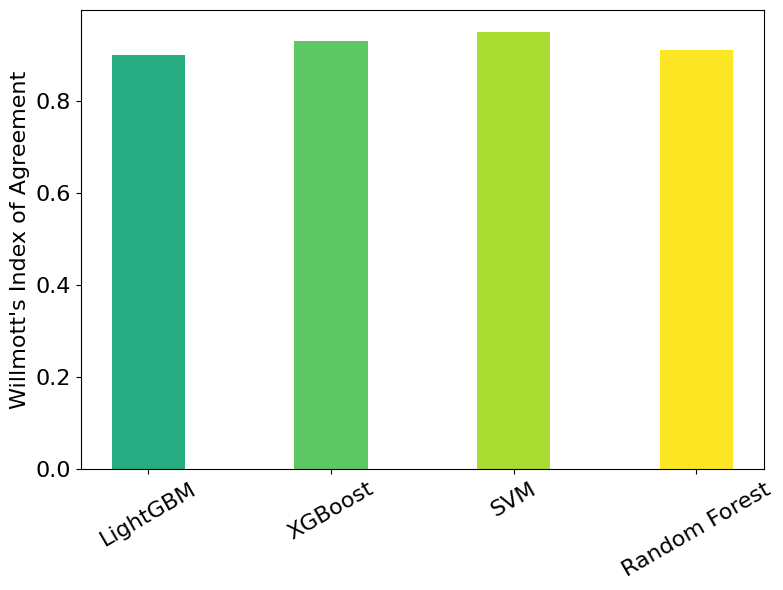

In [96]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 10. RUNOFF (m3/s) ANALYSIS

In [97]:
# Get the wind_min values
runoff = transformed_data[transformed_data['Parameter'] == parameters[4]]
runoff.head()

,Parameter,Date,Value
4,Runoff,1995-01-01,2.340
9,Runoff,1996-01-01,62.878
14,Runoff,1997-01-01,4.414
19,Runoff,1998-01-01,10.213
24,Runoff,1999-01-01,12.164


In [98]:
# drop the parameter columns
runoff = runoff.drop(columns=['Parameter'])

In [99]:
runoff.head()

,Date,Value
4,1995-01-01,2.340
9,1996-01-01,62.878
14,1997-01-01,4.414
19,1998-01-01,10.213
24,1999-01-01,12.164


In [100]:
# sort according to  the date
runoff = runoff.sort_values(by='Date')
runoff.head()

,Date,Value
4,1995-01-01,2.340
138,1995-02-01,2.553
272,1995-03-01,2.604
406,1995-04-01,10.093
540,1995-05-01,17.491


In [101]:
runoff.head()

,Date,Value
4,1995-01-01,2.340
138,1995-02-01,2.553
272,1995-03-01,2.604
406,1995-04-01,10.093
540,1995-05-01,17.491


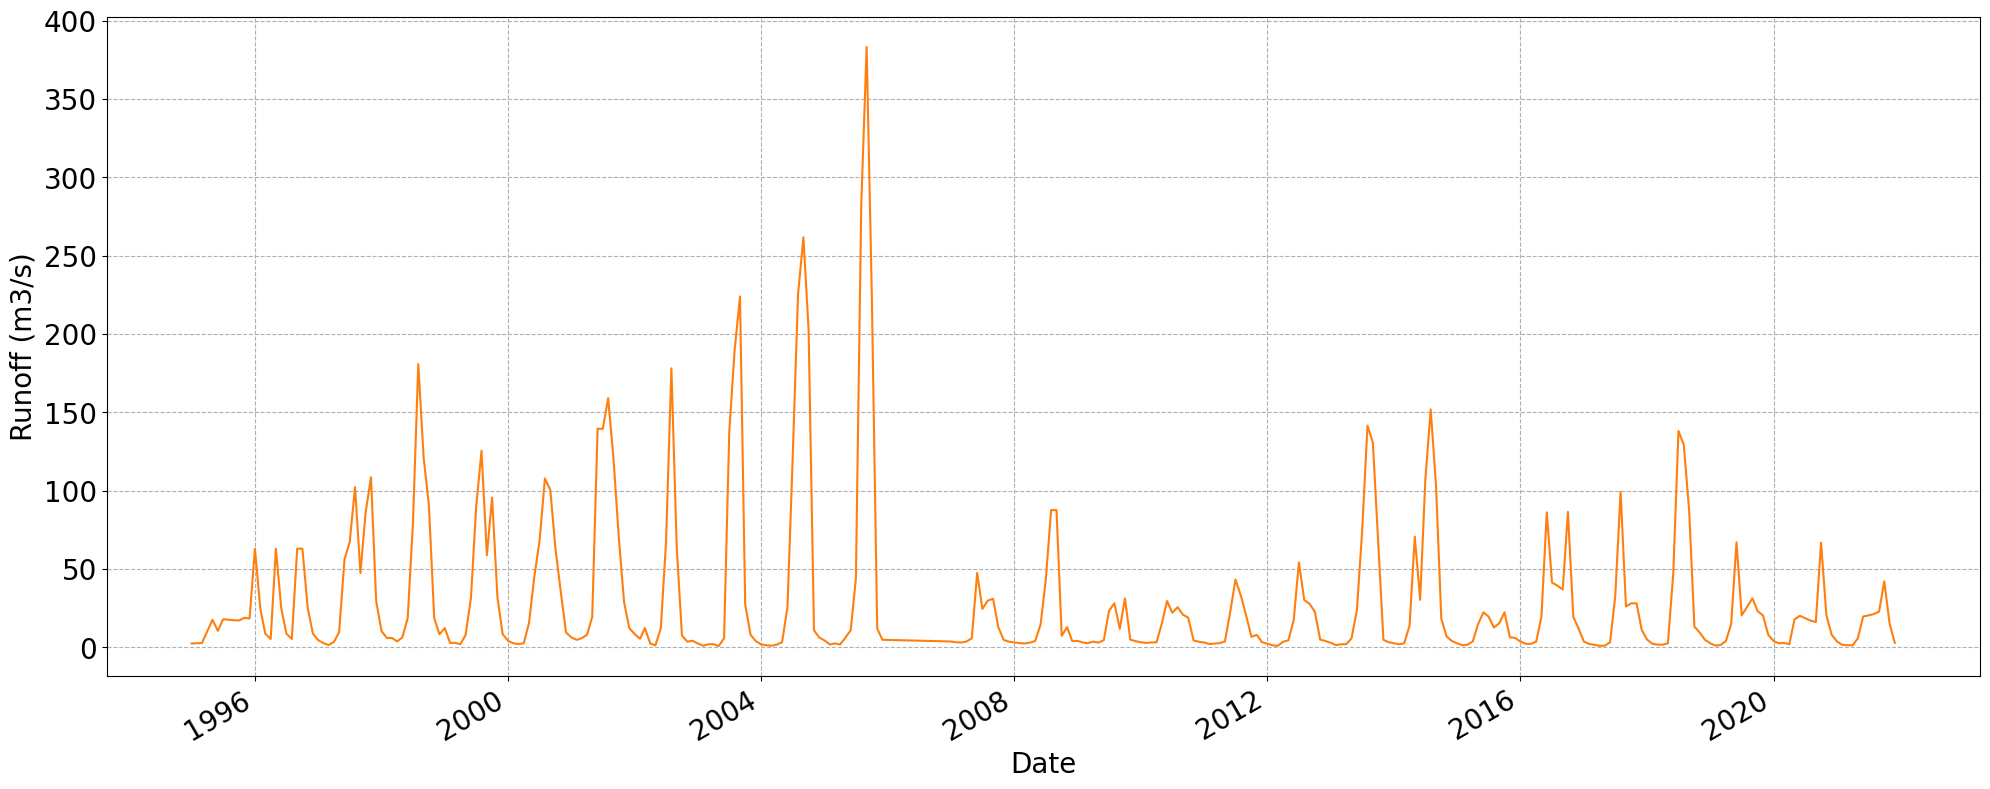

In [102]:
plt.figure(figsize=(20, 8))
runoff.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff7f0e', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Runoff (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [103]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [104]:
# H0: It is non stationary
# H1: It is stationary

In [105]:
adfuller_test(runoff['Value'])

ADF Test Statistic : -2.5872651063173273
p-value : 0.0956579797880519
#Lags Used : 11
Number of Observations Used : 300
Weak evidence against the null hypothesis(H0)


In [106]:
runoff = runoff[['Date', 'Value']]
runoff.set_index('Date', inplace=True)
runoff.head()

,Value
Date,
1995-01-01,2.340
1995-02-01,2.553
1995-03-01,2.604
1995-04-01,10.093
1995-05-01,17.491


In [107]:
runoff_model_names = []
runoff_mae_values = []
runoff_rmse_values = []
runoff_r2_values = []
runoff_nse_values = []
runoff_willmott_values = []

### TRAIN THE MODEL

In [108]:
# Assuming `runoff` is your time series DataFrame
series = runoff
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=0.5, predicted=0.4
>expected=0.3, predicted=0.1
>expected=0.2, predicted=0.5
>expected=-0.5, predicted=-0.4
>expected=-0.6, predicted=0.0
>expected=-0.5, predicted=-0.1
>expected=-0.4, predicted=-0.3
>expected=-0.4, predicted=-0.4
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.4, predicted=-0.5
>expected=-0.4, predicted=-0.3
>expected=-0.7, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.6
>expected=0.3, predicted=0.1
>expected=0.3, predicted=0.2
>expected=0.4, predicted=0.3
>expected=-0.4, predicted=-0.4
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.6, predicted=-0.7
>expected=-0.4, predicted=-0.3
>expected=-0.4, predicted=-0.2
>expected=-0.7, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=-0.3, predicted=-0.2
>expected=-0.2, predicted=-0.2
>expected=0.0, predicted=-0.1
>expected=0.5, predicted=0.5
>expected=0.3, predicted

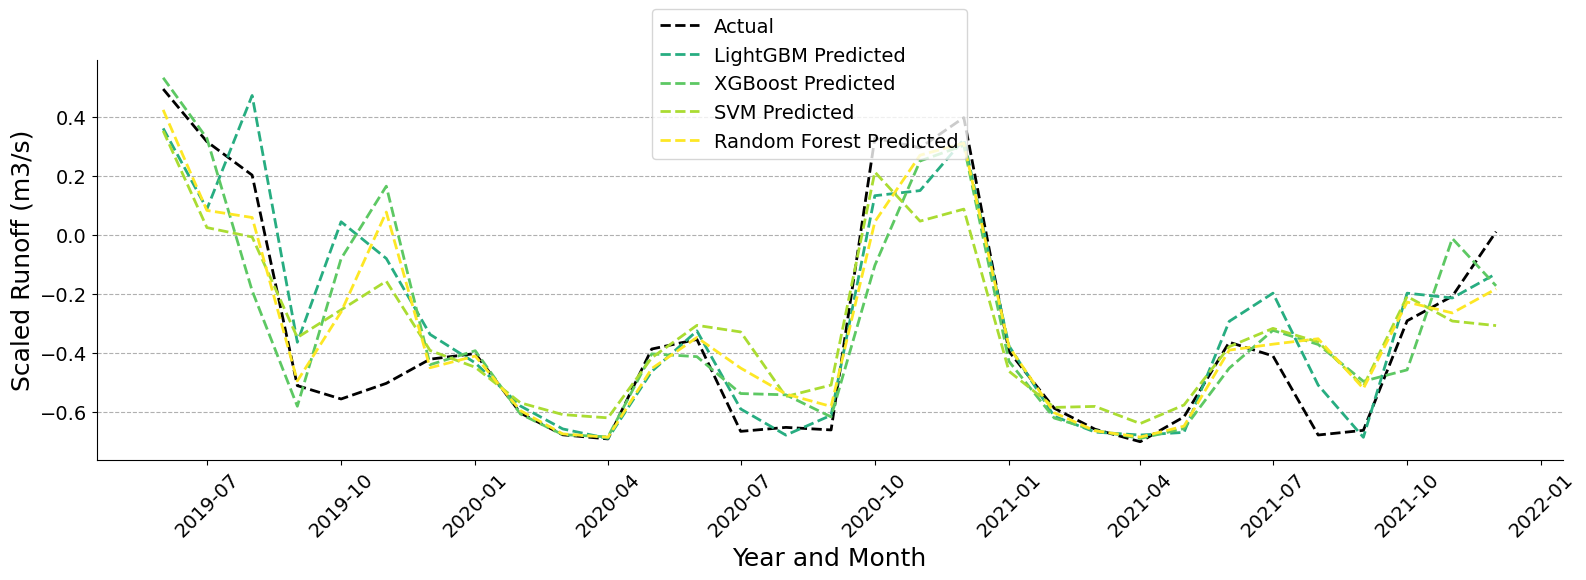

In [109]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Runoff (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [110]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [111]:
metrics

,Model,MAE,RMSE,R-squared,Nash-Sutcliffe Efficiency,Willmott's Index of Agreement
0,LightGBM,0.112303,0.170880,0.788446,0.788446,0.941741
1,XGBoost,0.126930,0.205061,0.695349,0.695349,0.912229
2,SVM,0.140481,0.178119,0.770143,0.770143,0.917059
3,Random Forest,0.101752,0.155099,0.825717,0.825717,0.948409


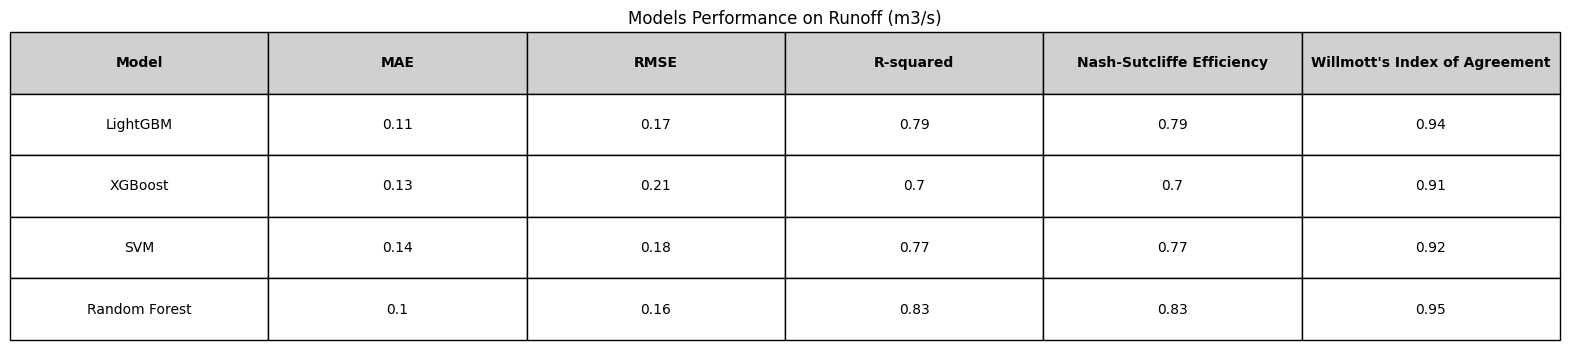

In [112]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Runoff (m3/s)')
plt.show()


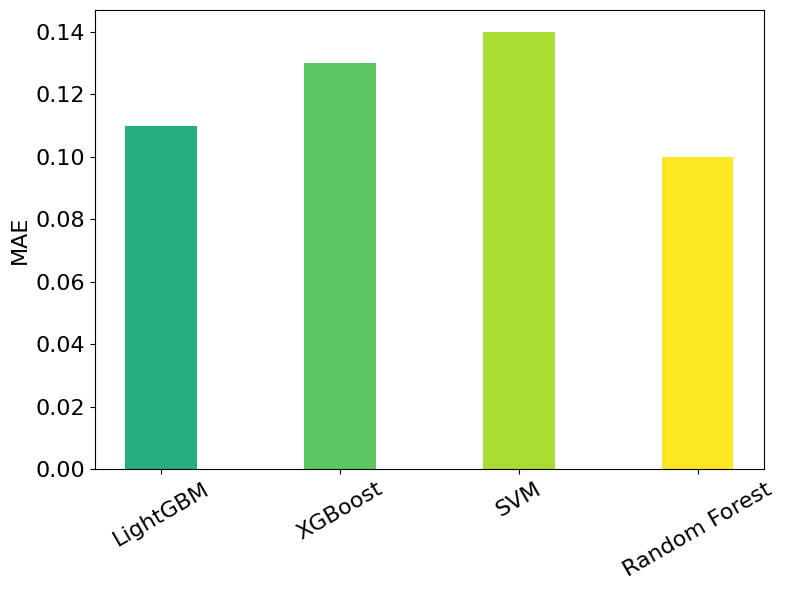

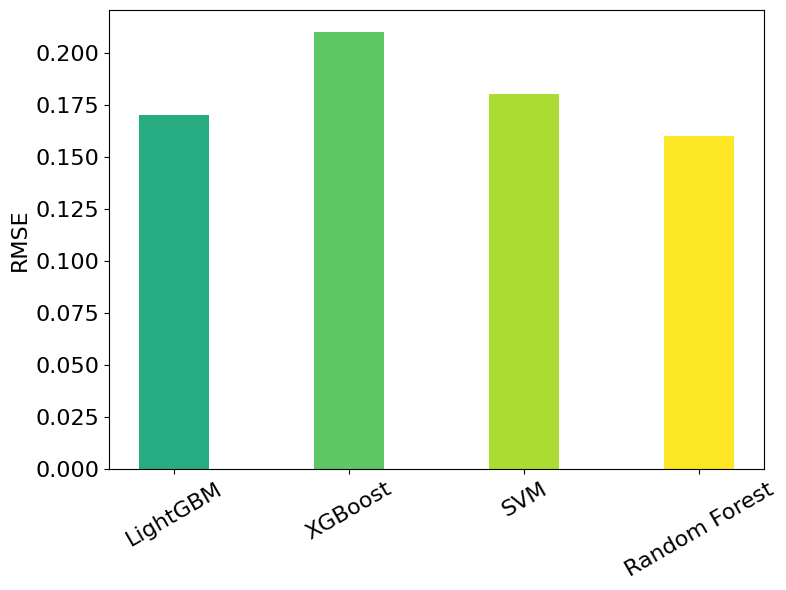

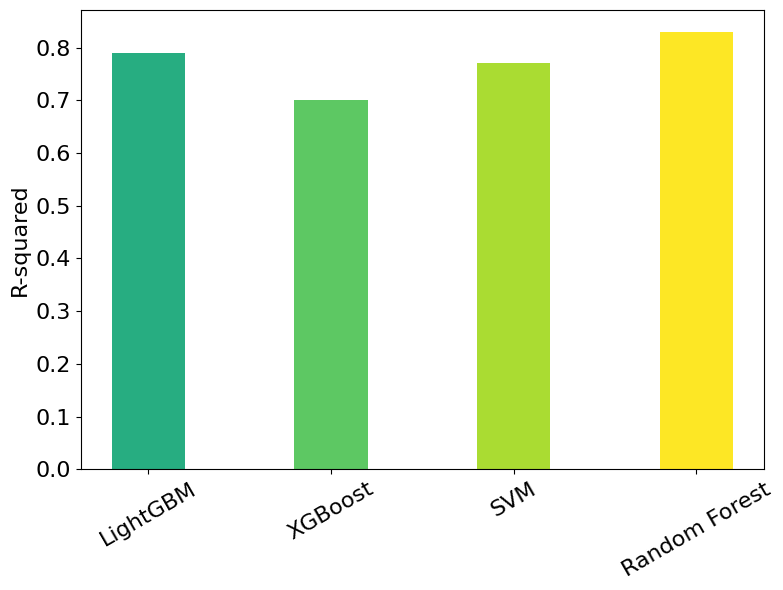

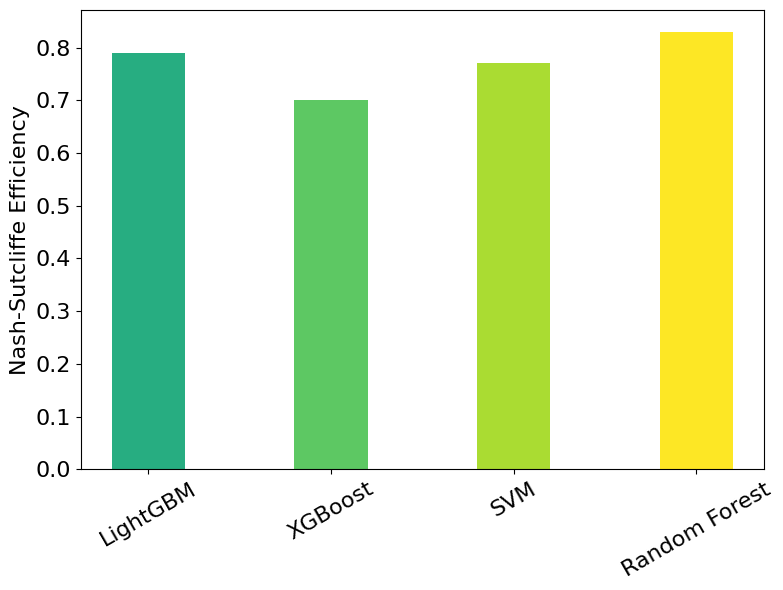

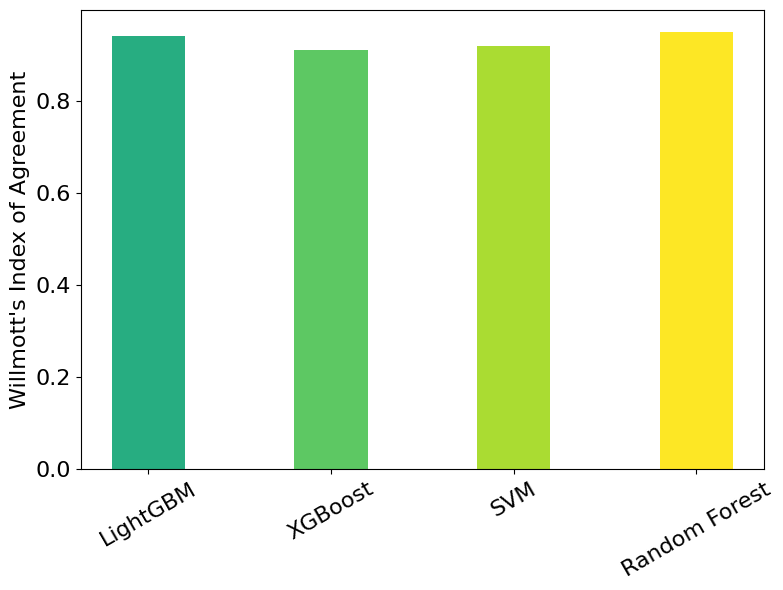

In [113]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

### The End